###  The code in this notebook can be used to replicate:
    1. Figure 2
    2. Extended Data Figure 2
    3. Extended Data Figure 3 a-h


#### Decode pipeline output files (provided in https://drive.google.com/drive/folders/1fz9QbWfl5JxM6HdYedPqg4sc5_K4yx7j?usp=sharing or generated by rerunning pipeline https://github.com/SlavovLab/decode/tree/main/decode_pipeline) required: 

    1. "Supplemental_Data_2.SAAP_proteins.xlsx"
    2. "Supplemental_Data_3.SAAP_precursor_quant.xlsx"
    3. "Supplemental_Data_4.SAAP_reporter_quant.xlsx" 
    4. "Reference_proteins_ranked_Median_RAAS.xlsx" (in pipeline_output/analysis_dependencies)
    5. "refnorm_AARS_abund_dict.p" (in pipeline_output/analysis_dependencies)
    6. "Meta.csv" (in pipeline_output/Savitski/MSFragger_validation/)
    7. "Supplemental_Data_5.SAAP_SILAC_quant.xlsx"
    8. "Median_normalized_Replicate_data_all_celltypes.csv" (in pipeline_output/Savitski/AA_subs_pipeline)
    9. "combined_modified_peptide_label_quant.tsv" (in pipeline_output/Savitski/MSFragger_validation/Hepatocytes/Results)
        a. pipeline_output/Savitski/MSFragger_validation/Hepatocytes/ must be unzipped
    10. "2024-07-21-decoys-contam-human_MTP_Hepatocytes.fasta.fas" (in pipeline_output/Savitski/databases)
    11. "qMTP_dict_[celltype].p" for each cell type in Savitski et al. (in pipeline_output/Savitski/AA_subs_pipeline)
    12. "unique_CPTAC_SAAP_BP_list.txt" (in pipeline_output/analysis_dependencies)
    13. "MTP_quant_dict.p" for each dataset (in pipeline_output/[dataset]/AA_subs_pipeline)
    14. "Ion_validated_MTP_dict.p" for each dataset (in pipeline_output/[dataset]/AA_subs_pipeline)
    15. "Tonsil_SAAP_dict.p" (in pipeline_output/HealthyTissues/AA_subs_pipeline)
    16. "Tonsil_BP_dict.p" (in pipeline_output/HealthyTissues/AA_subs_pipeline)
    17. "codon_frequencies.tsv" (in pipeline_output/analysis_dependencies)
    18. "Allprot_normalized_abundance_dict.p" for each dataset (in pipeline_output/[dataset]/AA_subs_pipeline)
    19. "blast_map_w_gene.xlsx" for each dataset (in pipeline_output/[dataset]/AA_subs_pipeline)
    


*** It is highly recommended to maintain the same directory structure as in the Google Drive ***


The code in this notebook is organized and labeled by references to figures in the manuscript.

In [1]:
# read in packages needed

import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from collections import Counter
import scipy as sp
from copy import deepcopy
from statsmodels.stats.multitest import multipletests
from adjustText import adjust_text
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator
import os
import ast
from scipy.odr import Model, RealData, ODR
from scipy.stats import gaussian_kde
from matplotlib import gridspec
#import milkviz as mv
from matplotlib_venn import venn3
import zipfile
from glob import glob
import gzip
import tarfile
from matplotlib.lines import Line2D
from matplotlib.ticker import AutoMinorLocator, FixedLocator
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

#### Setting directories and reading in data.

All of these directories should be updated by the user to reflect where their output data from the decode pipeline st stored.


In [8]:
proj_dir = os.getcwd()+'/'
dependencies_dir = proj_dir+'pipeline_output/analysis_dependencies/'
outdir = 'figures_testing/' # output directory where to save figures

# [dataset]_aa_subs_dir is the decode pipeline output folder
ccrcc_proj_dir = dependencies_dir+'CCRCC/'
ccrcc_aa_subs_dir = ccrcc_proj_dir+'AA_subs_pipeline/'
ccrcc_sample_map = pd.read_excel(ccrcc_aa_subs_dir+'sample_map.xlsx')
ccrcc_samples = ['S'+str(i) for i in list(set(ccrcc_sample_map['TMT plex']))]

ucec_proj_dir = dependencies_dir+'UCEC/'
ucec_aa_subs_dir = ucec_proj_dir+'AA_subs_pipeline/'
ucec_sample_map = pd.read_excel(ucec_aa_subs_dir+'sample_map.xlsx')
ucec_samples = ['S'+str(i) for i in list(set(ucec_sample_map['TMT plex']))]

brca_proj_dir = dependencies_dir+'BRCA/'
brca_aa_subs_dir = brca_proj_dir+'AA_subs_pipeline/'
brca_sample_map = pd.read_excel(brca_aa_subs_dir+'sample_map.xlsx')
brca_samples = ['S'+str(i) for i in list(set(brca_sample_map['TMT plex']))]

luad_proj_dir = dependencies_dir+'LUAD/'
luad_aa_subs_dir = luad_proj_dir+'AA_subs_pipeline/'
luad_sample_map = pd.read_excel(luad_aa_subs_dir+'sample_map.xlsx')
luad_samples = ['S'+str(i) for i in list(set(luad_sample_map['TMT plex']))]

pdac_proj_dir = dependencies_dir+'PDAC/'
pdac_aa_subs_dir = pdac_proj_dir+'AA_subs_pipeline/'
pdac_sample_map = pd.read_excel(pdac_aa_subs_dir+'sample_map.xlsx')
pdac_samples = ['S'+str(i) for i in list(set(pdac_sample_map['TMT plex']))]

lscc_proj_dir = dependencies_dir+'LSCC/'
lscc_aa_subs_dir = lscc_proj_dir+'AA_subs_pipeline/'
lscc_sample_map = pd.read_excel(lscc_aa_subs_dir+'sample_map.xlsx')
lscc_samples = ['S'+str(i) for i in list(set(lscc_sample_map['TMT plex']))]

wang_proj_dir = dependencies_dir+'HealthyTissues/'
wang_data_dir = wang_proj_dir+'AA_subs_pipeline/'
wang_samples = open(wang_data_dir+'proteomic_tissue_list.txt', 'r').read().split('\n')
wang_samples = [x for x in wang_samples if x!='rectum']

# lists used to quickly index dataset-specific sample maps (e.g.) from just the dataset name
datasets = ['CCRCC', 'UCEC', 'BRCA', 'LUAD', 'PDAC', 'LSCC', 'Healthy']
data_dir_list = [ccrcc_aa_subs_dir, ucec_aa_subs_dir, brca_aa_subs_dir, luad_aa_subs_dir, pdac_aa_subs_dir, lscc_aa_subs_dir, wang_data_dir]
samples_list = [ccrcc_samples, ucec_samples, brca_samples, luad_samples, pdac_samples, lscc_samples, wang_samples]
sample_map_list = [ccrcc_sample_map, ucec_sample_map, brca_sample_map, luad_sample_map, pdac_sample_map, lscc_sample_map]
proj_dir_list = [ccrcc_proj_dir, ucec_proj_dir, brca_proj_dir, luad_proj_dir, pdac_proj_dir, lscc_proj_dir, wang_proj_dir]


In [9]:
class GridShader():
    """
    function used to create alternating vertical gray and white background in plots
    """
    def __init__(self, ax, first=True, **kwargs):
        self.spans = []
        self.sf = first
        self.ax = ax
        self.kw = kwargs
        self.ax.autoscale(False, axis="x")
        self.cid = self.ax.callbacks.connect('xlim_changed', self.shade)
        self.shade()
    def clear(self):
        for span in self.spans:
            try:
                span.remove()
            except:
                pass
    def shade(self, evt=None):
        self.clear()
        xticks = self.ax.get_xticks()
        xlim = self.ax.get_xlim()
        xticks = xticks[(xticks > xlim[0]) & (xticks < xlim[-1])]
        locs = np.concatenate(([[xlim[0]], xticks, [xlim[-1]]]))

        start = [x-0.5 for x in locs[1-int(self.sf)::2]]
        end = [x-0.5 for x in locs[2-int(self.sf)::2]]

        for s, e in zip(start, end):
            self.spans.append(self.ax.axvspan(s, e, zorder=0, **self.kw))


def bihist(y1, y2, nbins=10, h=None):
    '''
    Function used to create violin plots as bihistograms with no smoothing.
    h is an axis handle. If not present, a new figure is created.
    '''
    if h is None: h = plt.figure().add_subplot(111)
    ymin = np.floor(np.minimum(min(y1), min(y2)))
    ymax = np.ceil(np.maximum(max(y1), max(y2)))
    bins = np.linspace(ymin, ymax, nbins)
    n1, bins1, patch1 = h.hist(y1, bins, orientation='horizontal', color='#AAAAAA', edgecolor=None, linewidth=0,rwidth=1)
    n2, bins2, patch2 = h.hist(y2, bins, orientation='horizontal', color='#AAAAAA', edgecolor=None, linewidth=0,rwidth=1)
    # set xmax:
    xmax = 0
    for i in patch1:
        i.set_edgecolor(None)
        width = i.get_width()
        if width > xmax: xmax = width
    # invert second histogram and set xmin:
    xmin = 0
    for i in patch2:
        i.set_edgecolor(None)
        width = i.get_width()
        width = -width
        i.set_width(width)
        if width < xmin: xmin = width
    h.set_xlim(xmin*1.1, xmax*1.1)          
    h.figure.canvas.draw()

# Figure 2 - RAAS

#### Incl. Extended Data Figures 2, 3 and Supplemental figures 6, 8

Read in dataframes generated for Supplemental Data Figures.
All data in these dataframes was taken from the dictionaries output from the decode pipeline

In [30]:
filt_saap_df = pd.read_excel(dependencies_dir+'Supplemental_Data_2.SAAP_proteins.xlsx', index_col=0)
filt_prec_quant_df = pd.read_excel(dependencies_dir+'Supplemental_Data_3.SAAP_precursor_quant.xlsx', index_col=0)
filt_reporter_quant_df = pd.read_excel(dependencies_dir+'Supplemental_Data_4.SAAP_reporter_quant.xlsx', index_col=0)

filt_saap_df_list = [filt_saap_df.loc[filt_saap_df['Dataset']==ds] for ds in datasets]
reporter_quant_df_list = [filt_reporter_quant_df.loc[filt_reporter_quant_df['Dataset']==ds] for ds in datasets[:-1]]
prec_quant_df_list = [filt_prec_quant_df.loc[filt_prec_quant_df['Dataset']==ds] for ds in datasets]

### Figure 2b. sample-level RAAS distribution 

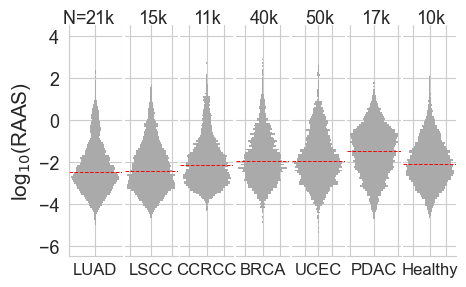

In [11]:
# sample/reporter ion level RAAS distributions for each dataset 

sns.set_style('whitegrid')
fig,axes = plt.subplots(1,len(datasets),figsize=(5,3), sharey=True)
plt.subplots_adjust(wspace=0.05)

for ax in axes:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params('x', bottom=False,labelbottom=False)
    if ax!=axes[0]:    
        ax.spines['left'].set_visible(False)
        ax.tick_params(left=False)

medians = [np.nanmedian(reporter_quant_df_list[i]['RAAS'].values) for i in range(len(datasets)-1)]
med_sort_idx = list(np.argsort(medians))
med_sort_idx.append(max(med_sort_idx)+1)

for i,ds in enumerate(datasets):
    ax_idx = med_sort_idx.index(i)
    axes[ax_idx].set_xlabel(ds, fontsize=12)
    if ds!='Healthy':
        ratio_data = [x for x in reporter_quant_df_list[i]['RAAS'].values if ~np.isnan(x) and ~np.isinf(x)]
    else:
        ratio_data = [x for x in prec_quant_df_list[i]['RAAS'].values if ~np.isnan(x) and ~np.isinf(x)]
    bihist(ratio_data, ratio_data, nbins=100,h=axes[ax_idx])
    if ax_idx==0:
        axes[ax_idx].annotate('N= ', (-0.1,1.01), xycoords='axes fraction', fontsize=13)
        axes[ax_idx].annotate(str(np.round(len(ratio_data), -3))[0:2]+'k', (0.32,1.01), xycoords='axes fraction', fontsize=13)
        
    else:
        axes[ax_idx].annotate(str(np.round(len(ratio_data), -3))[0:2]+'k', (0.25,1.01), xycoords='axes fraction', fontsize=13)
        
    axes[ax_idx].plot(axes[ax_idx].get_xlim(), (np.median(ratio_data), np.median(ratio_data)), '--r',linewidth=0.7)

axes[0].set_ylabel(r'log$_{10}$(RAAS)', fontsize=15)
axes[0].tick_params('y',labelsize=13)
axes[0].set_yticks([-6,-4,-2,0,2,4]);

plt.savefig(outdir+'Sample_level_RAAS_allDS.pdf', bbox_inches='tight')

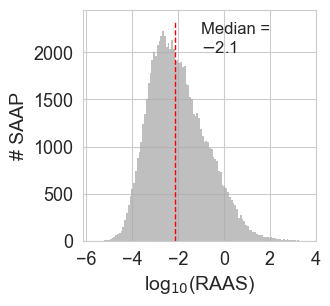

In [13]:
# fig 2b. sample-level RAAS distribution - all datasets in one distribution

sns.set_style('whitegrid')
fig,ax = plt.subplots(figsize=(3,3))

ratios = []
for i,ds in enumerate(datasets):
    if ds!='Healthy':
        ratio_data = [x for x in reporter_quant_df_list[i]['RAAS'].values if ~np.isnan(x) and ~np.isinf(x)]
    else:
        ratio_data = [x for x in prec_quant_df_list[i]['RAAS'].values if ~np.isnan(x) and ~np.isinf(x)]
    ratios = ratios + ratio_data
    
sns.histplot(ratios, color='#AAAAAA', linewidth=0)
plt.plot((np.median(ratios), np.median(ratios)),(plt.ylim()), '--r', linewidth=1)
ax.annotate('Median =\n$-$'+str(np.abs(np.round(np.median(ratios), 1))), (-1,2000), fontsize=12)
ax.set_ylabel(r'# SAAP', fontsize=14)
ax.set_xlabel(r'log$_{10}$(RAAS)', fontsize=14)
ax.tick_params('both',labelsize=13)
ax.set_xticks([-6,-4,-2,0,2,4]);

plt.savefig(outdir+'Sample_level_RAAS_allDS_onehistplot.pdf', bbox_inches='tight')

### Extended Data Figure 3a. Precursor ion-level RAAS distribution

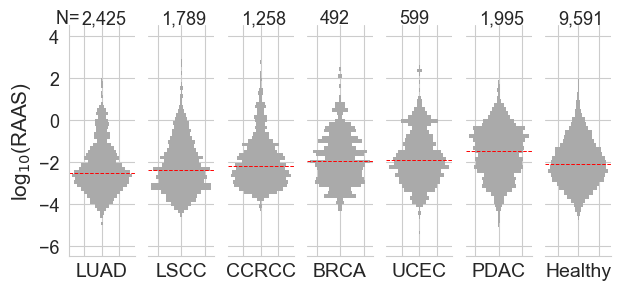

In [14]:
fig,axes = plt.subplots(1,len(datasets),figsize=(len(datasets),3), sharey=True)

sns.set_style('whitegrid')
for ax in axes:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params('x', bottom=False,labelbottom=False)
    if ax!=axes[0]:    
        ax.spines['left'].set_visible(False)
        ax.tick_params(left=False)

medians = [np.nanmedian(prec_quant_df_list[i]['RAAS'].values) for i in range(len(datasets)-1)]
med_sort_idx = list(np.argsort(medians))
med_sort_idx.append(max(med_sort_idx)+1)

for i,ds in enumerate(datasets):
    ax_idx = med_sort_idx.index(i)
    axes[ax_idx].set_xlabel(ds, fontsize=14)
    ratio_data = [x for x in prec_quant_df_list[i]['RAAS'].values if ~np.isnan(x) and ~np.isinf(x)]
    bihist(ratio_data, ratio_data, nbins=50,h=axes[ax_idx])
    if ax_idx==0:
        axes[ax_idx].annotate('N= ', (-0.2,1.01), xycoords='axes fraction', fontsize=13)
    axes[ax_idx].annotate('{:,}'.format((len(ratio_data))), (0.2,1.01), xycoords='axes fraction', fontsize=13)
    axes[ax_idx].plot(axes[ax_idx].get_xlim(), (np.median(ratio_data), np.median(ratio_data)), '--r',linewidth=0.7)

axes[0].set_ylabel(r'log$_{10}$(RAAS)', fontsize=15)
axes[0].tick_params('y',labelsize=13)

plt.savefig(outdir+'TMT_level_RAAS_allDS_nogrid.pdf', bbox_inches='tight')

### Extended Data Figure 3c. Sample median RAAS distributions

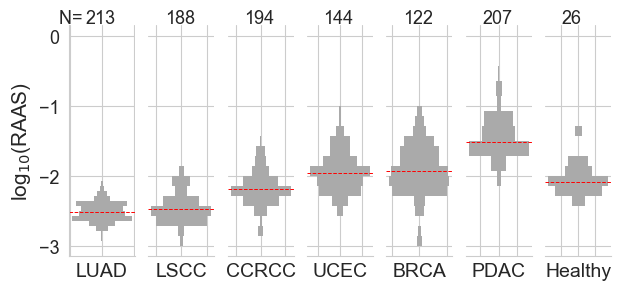

In [15]:
fig,axes = plt.subplots(1,len(datasets),figsize=(len(datasets),3), sharey=True)
#plt.ylim([-3.5,0])
sns.set_style('whitegrid')
for ax in axes:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params('x', bottom=False,labelbottom=False)
    if ax!=axes[0]:    
        ax.spines['left'].set_visible(False)
        ax.tick_params(left=False)

sample_median_values_list = []
for i,ds in enumerate(datasets):
    if ds!='Healthy':
        reporter_quant_df = reporter_quant_df_list[i]
        samples = list(set(reporter_quant_df['Sample name'].values))
        sample_medians = [np.nanmedian(reporter_quant_df.loc[reporter_quant_df['Sample name']==s, 'RAAS'].values) for s in samples]
        sample_median_values_list.append(sample_medians)
    else:
        prec_quant_df = prec_quant_df_list[i]
        samples = list(set(prec_quant_df['TMT/Tissue'].values))
        sample_medians = [np.nanmedian(prec_quant_df.loc[prec_quant_df['TMT/Tissue']==s, 'RAAS'].values) for s in samples]
        sample_median_values_list.append(sample_medians)
        
medians = [np.nanmedian(sample_median_values_list[i]) for i in range(len(datasets)-1)]
med_sort_idx = list(np.argsort(medians))
med_sort_idx.append(max(med_sort_idx)+1)

for i,ds in enumerate(datasets):
    ax_idx = med_sort_idx.index(i)
    axes[ax_idx].set_xlabel(ds, fontsize=14)
    ratio_data = [x for x in sample_median_values_list[i] if ~np.isnan(x) and ~np.isinf(x)]
    bihist(ratio_data, ratio_data, nbins=15,h=axes[ax_idx])
    if ax_idx==0:
        axes[ax_idx].annotate('N= ', (-0.15,1.01), xycoords='axes fraction', fontsize=13)
    axes[ax_idx].annotate('{:,}'.format((len(ratio_data))), (0.25,1.01), xycoords='axes fraction', fontsize=13)
    axes[ax_idx].plot(axes[ax_idx].get_xlim(), (np.median(ratio_data), np.median(ratio_data)), '--r',linewidth=0.7)

axes[0].set_ylabel(r'log$_{10}$(RAAS)', fontsize=15)
axes[0].tick_params('y',labelsize=13)

#plt.annotate('Cancer and normal adjacent tissue', (0.14,0.97), xycoords='figure fraction')
#plt.show()
plt.savefig(outdir+'Sample_median_RAAS_allDS.pdf', bbox_inches='tight')

### Extended data figure 3b. Median RAAS for all unique SAAP

/var/folders/jh/xlgb4y497ms2xscmydjlsrb40000gp/T/ipykernel_56726/1235919236.py:21: RuntimeWarning: All-NaN slice encountered
  saap_medians = [np.nanmedian(prec_quant_df.loc[prec_quant_df['SAAP']==s, 'RAAS'].values) for s in saap]


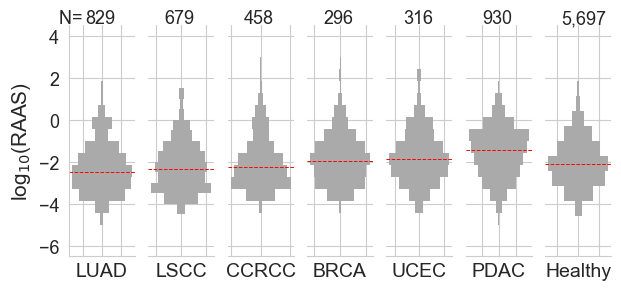

In [16]:
fig,axes = plt.subplots(1,len(datasets),figsize=(len(datasets),3), sharey=True)
sns.set_style('whitegrid')
for ax in axes:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params('x', bottom=False,labelbottom=False)
    if ax!=axes[0]:    
        ax.spines['left'].set_visible(False)
        ax.tick_params(left=False)

saap_median_values_list = []
for i,ds in enumerate(datasets):
    if ds!='Healthy':
        reporter_quant_df = reporter_quant_df_list[i]
        saap = list(set(reporter_quant_df['SAAP'].values))
        saap_medians = [np.nanmedian(reporter_quant_df.loc[reporter_quant_df['SAAP']==s, 'RAAS'].values) for s in saap]
        saap_median_values_list.append(saap_medians)
    else:
        prec_quant_df = prec_quant_df_list[i]
        saap = list(set(prec_quant_df['SAAP'].values))
        saap_medians = [np.nanmedian(prec_quant_df.loc[prec_quant_df['SAAP']==s, 'RAAS'].values) for s in saap]
        saap_median_values_list.append(saap_medians)
        
medians = [np.nanmedian(saap_median_values_list[i]) for i in range(len(datasets)-1)]
med_sort_idx = list(np.argsort(medians))
med_sort_idx.append(max(med_sort_idx)+1)

for i,ds in enumerate(datasets):
    ax_idx = med_sort_idx.index(i)
    axes[ax_idx].set_xlabel(ds, fontsize=14)
    ratio_data = [x for x in saap_median_values_list[i] if ~np.isnan(x) and ~np.isinf(x)]
    bihist(ratio_data, ratio_data, nbins=15,h=axes[ax_idx])
    if ax_idx==0:
        axes[ax_idx].annotate('N= ', (-0.15,1.01), xycoords='axes fraction', fontsize=13)
    axes[ax_idx].annotate('{:,}'.format((len(ratio_data))), (0.25,1.01), xycoords='axes fraction', fontsize=13)
    axes[ax_idx].plot(axes[ax_idx].get_xlim(), (np.median(ratio_data), np.median(ratio_data)), '--r',linewidth=0.7)

axes[0].set_ylabel(r'log$_{10}$(RAAS)', fontsize=15)
axes[0].tick_params('y',labelsize=13)

plt.savefig(outdir+'SAAP_median_RAAS_allDS.pdf', bbox_inches='tight')

### Extended data figure 3d. Medians of extended 3a-c.

/var/folders/jh/xlgb4y497ms2xscmydjlsrb40000gp/T/ipykernel_56726/454607856.py:27: RuntimeWarning: All-NaN slice encountered
  saap_medians = [np.nanmedian(prec_quant_df.loc[prec_quant_df['SAAP']==s, 'RAAS'].values) for s in saap]


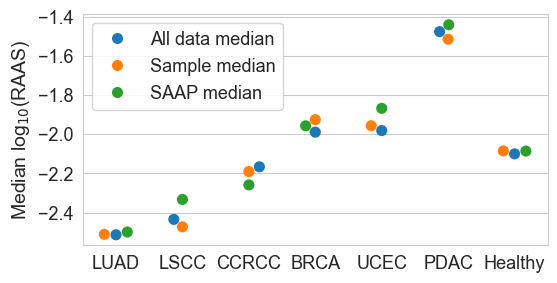

In [17]:
all_medians = [np.nanmedian(reporter_quant_df_list[i]['RAAS'].values) for i in range(len(datasets)-1)]
all_medians.append(np.nanmedian(prec_quant_df_list[-1]['RAAS'].values))
sample_median_values_list = []
for i,ds in enumerate(datasets):
    if ds!='Healthy':
        reporter_quant_df = reporter_quant_df_list[i]
        samples = list(set(reporter_quant_df['Sample name'].values))
        sample_medians = [np.nanmedian(reporter_quant_df.loc[reporter_quant_df['Sample name']==s, 'RAAS'].values) for s in samples]
        sample_median_values_list.append(sample_medians)
    else:
        prec_quant_df = prec_quant_df_list[i]
        samples = list(set(prec_quant_df['TMT/Tissue'].values))
        sample_medians = [np.nanmedian(prec_quant_df.loc[prec_quant_df['TMT/Tissue']==s, 'RAAS'].values) for s in samples]
        sample_median_values_list.append(sample_medians)
sample_medians = [np.nanmedian(sample_median_values_list[i]) for i in range(len(datasets))]

saap_median_values_list = []
for i,ds in enumerate(datasets):
    if ds!='Healthy':
        reporter_quant_df = reporter_quant_df_list[i]
        saap = list(set(reporter_quant_df['SAAP'].values))
        saap_medians = [np.nanmedian(reporter_quant_df.loc[reporter_quant_df['SAAP']==s, 'RAAS'].values) for s in saap]
        saap_median_values_list.append(saap_medians)
    else:
        prec_quant_df = prec_quant_df_list[i]
        saap = list(set(prec_quant_df['SAAP'].values))
        saap_medians = [np.nanmedian(prec_quant_df.loc[prec_quant_df['SAAP']==s, 'RAAS'].values) for s in saap]
        saap_median_values_list.append(saap_medians)
        
saap_medians = [np.nanmedian(saap_median_values_list[i]) for i in range(len(datasets))]

plot_rows = []
plot_cols = ['Dataset', 'Median RAAS', 'Median type']
for m, median in enumerate(all_medians):
    plot_rows.append([datasets[m], median, 'All data median'])
for m, median in enumerate(sample_medians):
    plot_rows.append([datasets[m], median, 'Sample median'])
for m, median in enumerate(saap_medians):
    plot_rows.append([datasets[m], median, 'SAAP median'])
    
plot_df = pd.DataFrame(plot_rows, columns=plot_cols)    

fig,ax = plt.subplots(figsize=(6,3))
sns.swarmplot(data=plot_df, x='Dataset', y='Median RAAS', hue='Median type', s=8,
              order=['LUAD','LSCC','CCRCC','BRCA','UCEC','PDAC','Healthy'])
plt.legend(title='', fontsize=13)
ax.tick_params('both', labelsize=13)
plt.ylabel('Median log$_{10}$(RAAS)', fontsize=14)
plt.xlabel('')
plt.savefig(outdir+'RAAS_distribution_median_comparison_swarmplot.pdf', bbox_inches='tight')

### Figure 2h. Proteins with high RAAS

In [18]:
# this dataframe was generated separately using the results from the protein set enrichment analysis 

ref_prot_df = pd.read_excel(dependencies_dir+'Reference_proteins_ranked_Median_RAAS.xlsx', index_col=0)

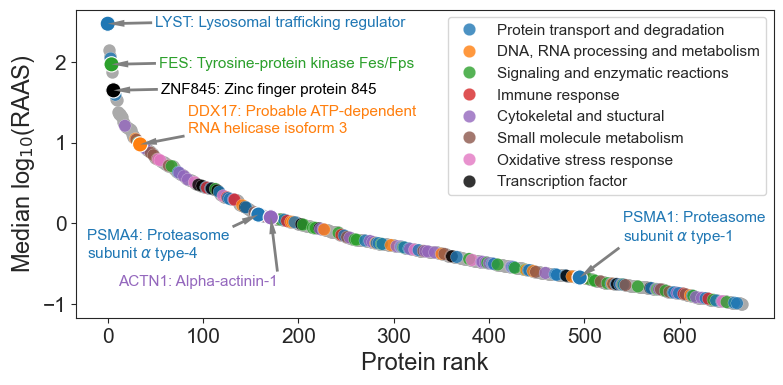

In [19]:
sns.set_style('ticks')
fig,ax = plt.subplots(figsize=(9,4))

hue_order=['Protein transport and degradation','DNA, RNA processing and metabolism','Signaling and enzymatic reactions', 'Immune response', 'Cytokeletal and stuctural', 'Small molecule metabolism', 'Oxidative stress response', 'Transcription factor']
nonpath_rows = [i for i,row in ref_prot_df.iterrows() if row['Median RAAS']>-1 and row['Pathway group'] not in hue_order]

sns.scatterplot(data=ref_prot_df.loc[nonpath_rows], x='Rank', y='Median RAAS', color='#aaaaaa', s=80, linewidth=0, alpha=1)
sns.scatterplot(data=ref_prot_df.loc[(ref_prot_df['Median RAAS']>-1) & (ref_prot_df['Pathway group']!='')], x='Rank', y='Median RAAS', s=80, hue='Pathway group', linewidth=0.2,alpha=0.8,
                palette=colors[0:7]+['black'], hue_order=hue_order)

ax.tick_params('both', labelsize=15)
plt.xlabel('Protein rank', fontsize=17)
plt.ylabel('Median log$_{10}$(RAAS)', fontsize=17)
plt.legend(title='', fontsize=11)

ranks2plot = [0,495,4,34,171, 158, 6]
sns.scatterplot(data=ref_prot_df.loc[ref_prot_df['Rank'].isin(ranks2plot)], x='Rank', y='Median RAAS', s=120, hue='Pathway group', linewidth=0.8, alpha=1,
                palette=colors[0:7]+['black'], hue_order=hue_order)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles[:8], labels=labels[:8], fontsize=11, bbox_to_anchor=(1,1))

texts2plot = ['LYST: Lysosomal trafficking regulator', 'PSMA1: Proteasome\n'+r'subunit $\alpha$ type-1',
             'FES: Tyrosine-protein kinase Fes/Fps', 'DDX17: Probable ATP-dependent\nRNA helicase isoform 3',
             'ACTN1: Alpha-actinin-1', 'PSMA4: Proteasome\n'+r'subunit $\alpha$ type-4', 
             'ZNF845: Zinc finger protein 845']
colors2plot = [colors[0], colors[0], colors[2], colors[1], colors[4], colors[0], 'black']

for i,rank in enumerate(ranks2plot):
    txt = texts2plot[i]
    y = ref_prot_df.loc[ref_prot_df['Rank']==rank,'Median RAAS']
    if 'Proteasome' not in txt and 'actin' not in txt and 'DDX' not in txt:
        ax.annotate(txt, xy=(rank,y), xytext=(rank+50,y+0.1), xycoords='data', textcoords='data', va='top',
                arrowprops=dict(facecolor='gray', headwidth=5,width=2, linewidth=0), color=colors2plot[i], fontsize=11)
    elif 'DDX' in txt:
        ax.annotate(txt, xy=(rank,y), xytext=(rank+50,y+0.3), xycoords='data', textcoords='data', va='center',
        arrowprops=dict(facecolor='gray', headwidth=5,width=2, linewidth=0), color=colors2plot[i], fontsize=11)
    elif 'type-4' in txt:
        ax.annotate(txt, xy=(rank,y), xytext=(rank-180,y-0.6), xycoords='data', textcoords='data', va='bottom',
        arrowprops=dict(facecolor='gray', headwidth=5,width=2, linewidth=0), color=colors2plot[i], fontsize=11)
    elif 'type-1' in txt:
        ax.annotate(txt, xy=(rank,y), xytext=(rank+45,y+0.4), xycoords='data', textcoords='data', va='bottom',
        arrowprops=dict(facecolor='gray', headwidth=5,width=2, linewidth=0), color=colors2plot[i], fontsize=11)
    else:
        ax.annotate(txt, xy=(rank,y), xytext=(rank-160,y-0.8), xycoords='data', textcoords='data', va='center',
        arrowprops=dict(facecolor='gray', headwidth=5,width=2, linewidth=0), color=colors2plot[i], fontsize=11)
plt.savefig(outdir+'Protein_group_RAAS_rank_plot.pdf', bbox_inches='tight')


### Figure 2e. Peptide precursor ion abundance relative to shared peptide 


In [31]:
def raas2bin(raas):
    """ function to bin RAAS values for plotting"""
    if raas<-3:
        raas_bin = '[-$\infty$,-3]'
    elif raas<-2:
        raas_bin = '(-3,-2]'
    elif raas<-1:
        raas_bin = '(-2,-1]'
    elif raas<0:
        raas_bin = '(-1,0]'
    elif raas<1:
        raas_bin = '(0,1]'
    else:
        raas_bin = '(1,$\infty$)'
    return(raas_bin)


# add RAAS bin and ratios of SAAP and BP to shared peptide abundance
filt_prec_quant_df['RAAS_bin'] = filt_prec_quant_df['RAAS'].apply(raas2bin)
filt_prec_quant_df['MTP/SP'] = np.nan
filt_prec_quant_df['BP/SP'] = np.nan

for i,row in filt_prec_quant_df.iterrows():
    mtp = row['SAAP abundance (no IE norm)']
    bp = row['BP abundance (no IE norm)']
    shared_p = row['Mean shared peptide precursor intensity']
    filt_prec_quant_df.loc[i,'MTP/SP'] = mtp/shared_p
    filt_prec_quant_df.loc[i, 'BP/SP'] = bp/shared_p

raas_bins = ['[-$\infty$,-3]', '(-3,-2]','(-2,-1]','(-1,0]','(0,1]','(1,$\infty$)']

<>:4: SyntaxWarning: invalid escape sequence '\i'
<>:14: SyntaxWarning: invalid escape sequence '\i'
<>:30: SyntaxWarning: invalid escape sequence '\i'
<>:30: SyntaxWarning: invalid escape sequence '\i'
<>:4: SyntaxWarning: invalid escape sequence '\i'
<>:14: SyntaxWarning: invalid escape sequence '\i'
<>:30: SyntaxWarning: invalid escape sequence '\i'
<>:30: SyntaxWarning: invalid escape sequence '\i'
/var/folders/jh/xlgb4y497ms2xscmydjlsrb40000gp/T/ipykernel_56726/3313531673.py:4: SyntaxWarning: invalid escape sequence '\i'
  raas_bin = '[-$\infty$,-3]'
/var/folders/jh/xlgb4y497ms2xscmydjlsrb40000gp/T/ipykernel_56726/3313531673.py:14: SyntaxWarning: invalid escape sequence '\i'
  raas_bin = '(1,$\infty$)'
/var/folders/jh/xlgb4y497ms2xscmydjlsrb40000gp/T/ipykernel_56726/3313531673.py:30: SyntaxWarning: invalid escape sequence '\i'
  raas_bins = ['[-$\infty$,-3]', '(-3,-2]','(-2,-1]','(-1,0]','(0,1]','(1,$\infty$)']
/var/folders/jh/xlgb4y497ms2xscmydjlsrb40000gp/T/ipykernel_56726/33135

/var/folders/jh/xlgb4y497ms2xscmydjlsrb40000gp/T/ipykernel_56726/4005909053.py:13: RuntimeWarning: divide by zero encountered in log10
  rbin_data = [np.log10(x) for x in filt_prec_quant_df.loc[filt_prec_quant_df['RAAS_bin']==rbin, 'MTP/SP'].values]
/var/folders/jh/xlgb4y497ms2xscmydjlsrb40000gp/T/ipykernel_56726/4005909053.py:16: RuntimeWarning: divide by zero encountered in log10
  rbin_data = [np.log10(x) for x in filt_prec_quant_df.loc[filt_prec_quant_df['RAAS_bin']==rbin, 'BP/SP'].values]


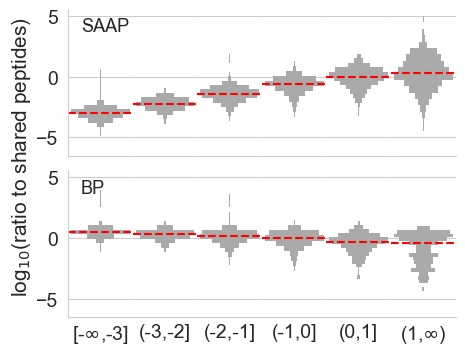

In [32]:
# plot distributions of abundance of SAAP/BP to shared peptide abundance as a function of RAAS

fig,axi = plt.subplots(2, len(raas_bins), figsize=(5,4), sharey=True)#, sharex=True)
plt.subplots_adjust(wspace=0, hspace=0.1)
sns.set_style('whitegrid')
for j, axes in enumerate(axi):
    for i,rbin in enumerate(raas_bins):
        ax = axes[i]
        if j==1:
            ax.set_xlabel(rbin, fontsize=14);
        ax.set_xticks([])
        if j==0:
            rbin_data = [np.log10(x) for x in filt_prec_quant_df.loc[filt_prec_quant_df['RAAS_bin']==rbin, 'MTP/SP'].values]
            peptype = 'SAAP'
        else:
            rbin_data = [np.log10(x) for x in filt_prec_quant_df.loc[filt_prec_quant_df['RAAS_bin']==rbin, 'BP/SP'].values]
            peptype = 'BP'

        rbin_data = [x for x in rbin_data if (~np.isnan(x)) and (~np.isinf(x))]
        bihist(rbin_data, rbin_data, nbins=20, h=ax)
        if i>0:
            ax.spines['left'].set_visible(False)
           # ax.set_yticks([])
        ax.spines['top'].set_visible(False)

        median_abund = np.nanmedian(rbin_data)
       # print(rbin, median_abund)
        ax.plot(ax.get_xlim(), (median_abund, median_abund), '--r')

        if ax==axes[-1]:
            ax.spines['right'].set_visible(False)
        #ax.set_ylim([-4.5,4])

    axes[0].tick_params('y', labelsize=14)
    #axes[0].set_yticks([-4,-2,0,2,4], labels=[-4,-2,0,2,'']);
    axes[0].annotate(peptype, (0.2, 0.85), xycoords='axes fraction', fontsize=13)   
axi[1][0].annotate('log$_{10}$(ratio to shared peptides)', (-0.9,1.1), xycoords='axes fraction', fontsize=15, 
                   rotation='vertical', va='center')
    
plt.savefig(outdir+'SAAP_BP_SP_ratio_bihist_RAASbins_allDS.pdf', bbox_inches='tight')    

### Figure 2d. FBP1 SAAP, BP and shared peptide abundance

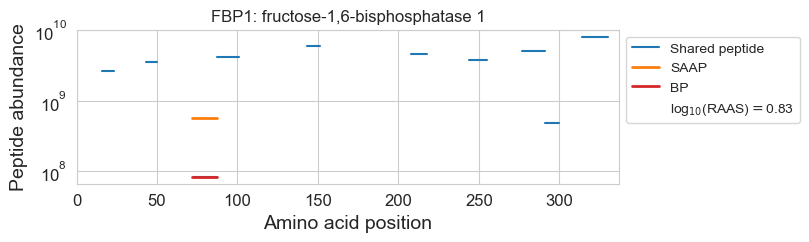

In [44]:
# read in file with shared peptide info for each confidently localized SAAP 
filt_saap2plot_df = pd.read_excel(dependencies_dir+'Plotted_shared_peptide_data.xlsx')

# function to get the position range of peptide in protein sequence
def get_pep_idx_range(pep, protseq):
    pattern = re.compile(re.escape(pep))  # Escape the substring for literal matching
    for match in pattern.finditer(protseq):
        start, end = match.start(), match.end()
    return(start, end)



# create plot with peptide intensity on the y axis, protein position on the x axis and plot a data point for each peptide

#count=0
gene = 'FBP1;FBP'
r = [i for i, row in filt_saap2plot_df.iterrows() if row['Gene']==gene]
saap_row = filt_saap2plot_df.loc[r]

#for r, saap_row in filt_saap2plot_df.iterrows():
   # if r>count:
    #print(count)
    #count+=1

peps = ast.literal_eval(saap_row['Used_shared_peptides'].values[0])
prot = saap_row['Reference protein'].values[0]
uniprot = saap_row['Uniprot_ID'].values[0]
ens = saap_row['Protein'].values[0]
#gene = saap_row['Gene']
protseq = saap_row['Protein_sequence'].values[0]
x_vals = [i for i in range(len(protseq))]
saap = saap_row['SAAP'].values[0]
saap_intensity = saap_row['SAAP abund no IE norm'].values[0]
bp = saap_row['BP'].values[0]
bp_intensity = saap_row['BP abund no IE norm'].values[0]

if bp in protseq and not isinstance(peps, float):
    ranges = []
    for pep in peps:
        if pep in protseq:
            start, end = get_pep_idx_range(pep, protseq)
            ranges.append([start, end])
        else: ranges.append([0,0])

    try:
        pep_intensities = ast.literal_eval(saap_row['Fixed_peptide_intensities'].values[0])#[0]
    except:
        pep_intensities = [float(x) for x in saap_row['Fixed_peptide_intensities'][1:-1].split(', ')]
    peps = [peps[i] for i in range(len(peps)) if ~np.isnan(pep_intensities[i])]
    pep_intensities = [x for x in pep_intensities if ~np.isnan(x)]
    
    if len(peps)>0 and np.nanmedian(pep_intensities)!=0:

        bp_range = get_pep_idx_range(bp, protseq)
        saap_range = bp_range
        raas = saap_row['RAAS'].values[0]

        fig,ax = plt.subplots(figsize=(7,2))
        plt.xlim([x_vals[0], x_vals[-1]])
        plt.xticks()
        plt.yscale('log')

        for i,pep in enumerate(peps):
            if pep!=bp and len(pep_intensities)>i:
                pep_int = pep_intensities[i]
                pep_range = ranges[i]
                pep_start = pep_range[0]
                pep_end = pep_range[1]
                
                if i==0:
                    plt.plot((pep_start, pep_end), (pep_int, pep_int), color=colors[0], label='Shared peptide') # only have once in legend
                else:
                    plt.plot((pep_start, pep_end), (pep_int, pep_int), color=colors[0])

        plt.plot([saap_range[0], saap_range[1]], (saap_intensity, saap_intensity), color=colors[1], label='SAAP', linewidth=2)
        plt.plot([bp_range[0], bp_range[1]], (bp_intensity, bp_intensity), color=colors[3], label='BP', linewidth=2)

        
        plt.ylabel('Peptide abundance', fontsize=14)
        plt.xlabel('Amino acid position', fontsize=14)
        ax.tick_params('both', labelsize=12)

        handles, labels = ax.get_legend_handles_labels()
        handles = handles + [Line2D([],[], c='w',marker=None)]
        labels = labels + [r'log$_{10}$(RAAS)$=$'+'{:.2f}'.format(raas)]
        plt.legend(handles=handles, labels=labels, bbox_to_anchor=(1,1))

        plot_str = gene
        if not isinstance(gene, str):
            plot_str = ens
        plot_str = plot_str.replace('/', '_')

        # if gene=='EHHADH;ECHD':
        #    plot_str = 'EHHADH: peroxisomal bifunctional enzyme isoform'
        #elif gene == 'CYB5R3;DIA1':
        #    plot_str = 'CYB5R3: NADH-cytochrome b5 reductase 3 isoform 3'
        if gene== 'FBP1;FBP':
            plot_str = 'FBP1: fructose-1,6-bisphosphatase 1'
        # elif gene == 'ALH5A1;SSADH':
        #     plot_str = 'SSADH: succinate-semialdehyde dehydrogenase'
        # elif gene == 'GSN':
        #    plot_str = 'GSN: gelsolin isoform a'
        #elif gene == 'PRPS1':
        #    plot_str = 'PRPS1: ribose-phosphate pyrophosphokinase 1 isoform 1'
        #elif gene == 'FKSG13;PTRF;CAVIN1':
        #    plot_str = 'CAVIN1: caveolae-associated protein 1'

        # plt.show()
        plt.title(plot_str)# + ': '+prot)
        plt.savefig(outdir+plot_str+'.pdf', bbox_inches='tight')
        plt.savefig(outdir+plot_str+'.png',dpi=300, bbox_inches='tight')
        #plt.close()


### Extended data figure 2l: Correlations of SAAP|BP to SP across all samples

In [45]:
# get a dataframe of the correlations of SAAP/BP abundances to shared peptide abundance 
# at the reporter ion level, across all sampls

corr_dfs = []
for d,ds in enumerate(datasets[:-1]):
    print(ds)
    ds_df = filt_reporter_quant_df.loc[filt_reporter_quant_df['Dataset']==ds]
    set_peps = list(set(ds_df['SAAP']))

    corr_rows = []
    corr_cols = ['Dataset','SAAP','BP', 'N samples', 'RAAS list', 'Median RAAS', 'SAAP corr to mean SP', 'BP corr to mean SP']
    for i,pep in enumerate(set_peps):
        pep_df = ds_df.loc[ds_df['SAAP']==pep]
        set_bps = list(set(pep_df['BP']))
        for bp in set_bps:
            pep_bp_df = pep_df.loc[pep_df['BP']==bp]
            pep_bp_df = pep_bp_df.loc[~np.isnan(pep_bp_df['Mean shared peptide reporter intensity'])]
            if len(pep_bp_df)>=10:
                SAAP_corr = sp.stats.pearsonr(pep_bp_df['SAAP abundance'], pep_bp_df['Mean shared peptide reporter intensity'])[0]
                bp_corr = sp.stats.pearsonr(pep_bp_df['BP abundance'], pep_bp_df['Mean shared peptide reporter intensity'])[0]
                raas_list = list(pep_bp_df['RAAS'].values)
                n_samples = len(raas_list)
                median_raas = np.nanmedian(raas_list)
                corr_rows.append([ds, pep, bp, n_samples, raas_list, median_raas, SAAP_corr, bp_corr])
    
    corr_df = pd.DataFrame(corr_rows, columns=corr_cols)
    corr_df['RAAS bin'] = corr_df['Median RAAS'].apply(raas2bin)
    corr_df['SAAP - BP corr'] = [row['SAAP corr to mean SP']-row['BP corr to mean SP'] for i,row in corr_df.iterrows()]
    corr_df.dropna(how='any', axis=0, inplace=True)
    corr_dfs.append(corr_df)
    
all_corr_df = pd.concat(corr_dfs)
all_corr_df.reset_index(inplace=True)

CCRCC
UCEC
BRCA
LUAD
PDAC
LSCC


328
[-$\infty$,-3] 0.6111387486754435
497
(-3,-2] 0.5323300540623603
381
(-2,-1] 0.5829840378950816
246
(-1,0] 0.49956958008974756
75
(0,1] 0.51494667102503
20
(1,$\infty$) 0.7174952869596598


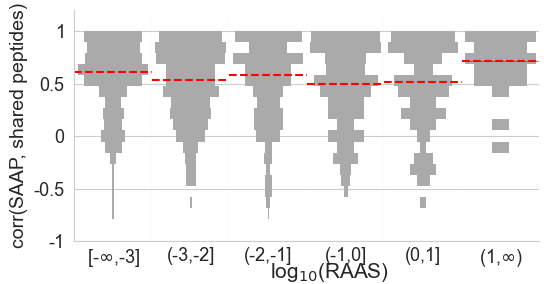

In [46]:
# plot violin plots of correlation distributions as function of RAAS for SAAP (middle panel)

fig,axes = plt.subplots(1, len(raas_bins), figsize=(6,3), sharey=True)
plt.subplots_adjust(wspace=0)
plt.ylim([-1,1.2])
sns.set_style('whitegrid')
for i,rbin in enumerate(raas_bins):
    ax = axes[i]
    #ax.set_ylim([-0.5,1])
    ax.set_xlabel(rbin, fontsize=13)
    ax.set_xticks([])
    rbin_data = all_corr_df.loc[all_corr_df['RAAS bin']==rbin, 'SAAP corr to mean SP'].values
    print(len(rbin_data))
    
    bihist(rbin_data, rbin_data, nbins=20, h=ax)
    if i>0:
        ax.spines['left'].set_visible(False)
       # ax.set_yticks([])
    ax.spines['top'].set_visible(False)

    median_corr = np.nanmedian(rbin_data)
    print(rbin, median_corr)
    ax.plot(ax.get_xlim(), (median_corr, median_corr), '--r')
     
    if ax==axes[-1]:
        ax.spines['right'].set_visible(False)
        ax.plot(ax.get_xlim(), (median_corr, median_corr), '--r', linewidth=0.5)
axes[0].set_ylabel('corr(SAAP, shared peptides)', fontsize=14)
axes[0].set_yticks([-1, -0.5,0,0.5,1])
axes[0].set_yticklabels([-1, -0.5,0,0.5,1], fontsize=13);

plt.annotate(r'log$_{10}$(RAAS)',(0.45,0.02), xycoords=('figure fraction'), fontsize=15)
plt.savefig(outdir+'SAAP_corr_to_median_SP.png', dpi=300, bbox_inches='tight')    

[-$\infty$,-3] 0.9321676436429179
(-3,-2] 0.8853129510842785
(-2,-1] 0.8350935891543321
(-1,0] 0.7862042620195087
(0,1] 0.7738767343983075
(1,$\infty$) 0.7387370293696911


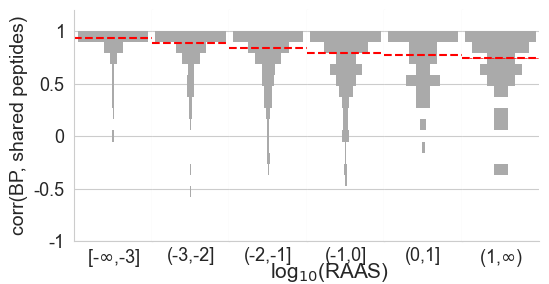

In [47]:
# plot violin plots of correlation distributions as function of RAAS for SAAP (top panel)

fig,axes = plt.subplots(1, len(raas_bins), figsize=(6,3), sharey=True)
plt.subplots_adjust(wspace=0)
plt.ylim([-1,1.2])
sns.set_style('whitegrid')
for i,rbin in enumerate(raas_bins):
    ax = axes[i]
    #ax.set_ylim([-0.5,1])
    ax.set_xlabel(rbin, fontsize=13)
    ax.set_xticks([])
    rbin_data = all_corr_df.loc[all_corr_df['RAAS bin']==rbin, 'BP corr to mean SP'].values
    
    bihist(rbin_data, rbin_data, nbins=20, h=ax)
    if i>0:
        ax.spines['left'].set_visible(False)
       # ax.set_yticks([])
    ax.spines['top'].set_visible(False)

    median_corr = np.nanmedian(rbin_data)
    print(rbin, median_corr)
    ax.plot(ax.get_xlim(), (median_corr, median_corr), '--r')
     
    if ax==axes[-1]:
        ax.spines['right'].set_visible(False)
        ax.plot(ax.get_xlim(), (median_corr, median_corr), '--r', linewidth=0.5)
axes[0].set_ylabel('corr(BP, shared peptides)', fontsize=14)
axes[0].set_yticks([-1, -0.5,0,0.5,1])
axes[0].set_yticklabels([-1, -0.5,0,0.5,1], fontsize=13);

plt.annotate(r'log$_{10}$(RAAS)',(0.45,0.02), xycoords=('figure fraction'), fontsize=15)
plt.savefig(outdir+'BP_corr_to_median_SP.png', dpi=300, bbox_inches='tight')    

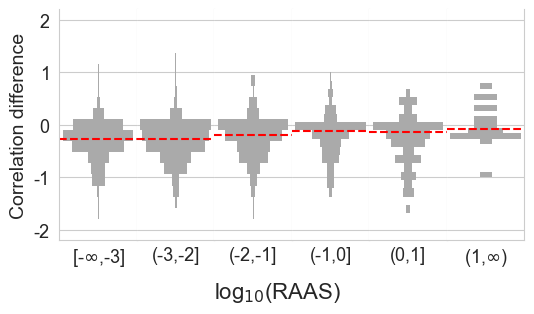

In [48]:
# plot violin plots of difference in correlation between SAAP and BP (lower panel)

fig,axes = plt.subplots(1, len(raas_bins), figsize=(6,3), sharey=True)
plt.subplots_adjust(wspace=0)
sns.set_style('whitegrid')
for i,rbin in enumerate(raas_bins):
    ax = axes[i]
    ax.set_xlabel(rbin, fontsize=13)
    ax.set_xticks([])
    rbin_data = [x for x in all_corr_df.loc[all_corr_df['RAAS bin']==rbin, 'SAAP - BP corr'].values if (~np.isnan(x) and (~np.isinf(x)))]
    
    bihist(rbin_data, rbin_data, nbins=20, h=ax)
    if i>0:
        ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)

    median_corr = np.nanmedian(rbin_data)
    ax.plot(ax.get_xlim(), (median_corr, median_corr), '--r')

axes[0].set_ylabel('Correlation difference', fontsize=14)
axes[0].set_yticks([-2,-1,0,1,2])
axes[0].set_yticklabels([-2,-1,0,1,2], fontsize=13);


axes[2].annotate('log$_{10}$(RAAS)',(0,-0.25), xycoords=('axes fraction'), fontsize=16)

plt.savefig(outdir+'SAAP_minus_BP_corr_to_SP.png', dpi=300, bbox_inches='tight')    

### Extended data figure 2d,e,f: ionization efficiency normalization

CCRCC
UCEC
BRCA
LUAD
PDAC
LSCC
Healthy


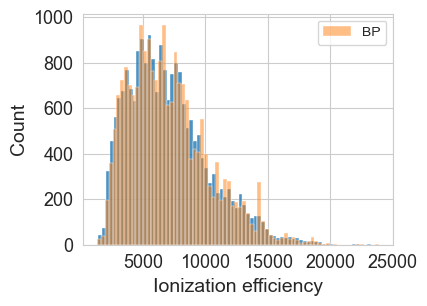

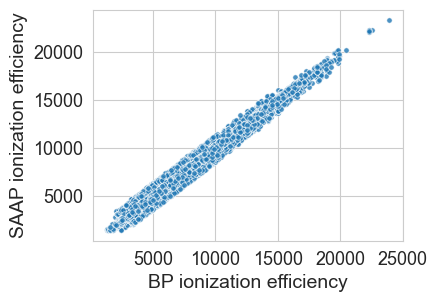

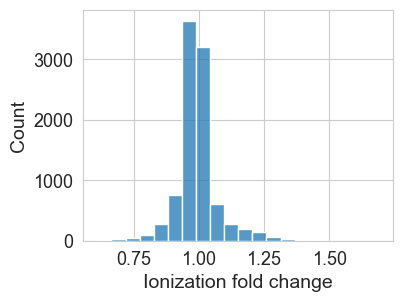

In [49]:
# ionization efficiencies for peptides and normalization of abundances are computed in decode pipeline quant
# here read in data from MTP_quant_dict.p and plot 

all_ds_mtp_ie = []
all_ds_bp_ie = []

for ds in datasets:
    print(ds)
    data_dir = data_dir_list[datasets.index(ds)]
    quant_dict = pickle.load(open(data_dir+'MTP_quant_dict.p', 'rb'))

    ds_mtp_ie = []
    ds_bp_ie = []
    for q,qdict in quant_dict.items():
        ds_mtp_ie.append(qdict['IE_dict']['MTP_IE'])
        ds_bp_ie.append(qdict['IE_dict']['BP_IE'])
    all_ds_mtp_ie = all_ds_mtp_ie + ds_mtp_ie
    all_ds_bp_ie = all_ds_bp_ie + ds_bp_ie
    
# plot histogram with SAAP and BP ionization efficiencies (Ext. Data Fig. 2d)
fig,ax = plt.subplots(figsize=(4,3))
sns.histplot(all_ds_mtp_ie, alpha=0.8, label='SAAP')
sns.histplot(all_ds_bp_ie, alpha=0.5,color=colors[1], label='BP')
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles[1:], labels=labels[1:])
plt.xlabel('Ionization efficiency', fontsize=14)
plt.ylabel('Count', fontsize=14)
ax.tick_params('both', labelsize=13)
plt.savefig(outdir+'All_peptide_IE_hist.pdf', bbox_inches='tight')
#plt.close()

# plot a correlation plot of SAAP to BP ionization efficiency (Ext. Data Fig. 2e)
fig,ax = plt.subplots(figsize=(4,3))
sns.scatterplot(y=all_ds_mtp_ie, x=all_ds_bp_ie, alpha=0.8, s=15, linewidth=0.5)
plt.xlabel('BP ionization efficiency', fontsize=14)
plt.ylabel('SAAP ionization efficiency', fontsize=14)
ax.tick_params('both', labelsize=13)
plt.savefig(outdir+'All_peptide_IE_corr.png', dpi=300, bbox_inches='tight')
#plt.close()

# plot a distribution of the fold changes between SAAP and BP ionization efficiencies (Ext. Data Fig. 2f)
ie_fc = [all_ds_mtp_ie[i]/all_ds_bp_ie[i] for i in range(len(ds_mtp_ie))]
fig,ax=plt.subplots(figsize=(4,3))
sns.histplot(ie_fc, bins=20)
plt.xlabel('Ionization fold change', fontsize=14)
plt.ylabel('Count', fontsize=14)
ax.tick_params('both', labelsize=13)
plt.savefig(outdir+'All_saap_bp_IE_FC.pdf', bbox_inches='tight')
#plt.close()

### Extended data figure 2a,b,c: N frags, PEP, mass error of high vs low RAAS

<>:36: SyntaxWarning: invalid escape sequence '\g'
<>:44: SyntaxWarning: invalid escape sequence '\g'
<>:54: SyntaxWarning: invalid escape sequence '\g'
<>:36: SyntaxWarning: invalid escape sequence '\g'
<>:44: SyntaxWarning: invalid escape sequence '\g'
<>:54: SyntaxWarning: invalid escape sequence '\g'
/var/folders/jh/xlgb4y497ms2xscmydjlsrb40000gp/T/ipykernel_56726/1576204221.py:36: SyntaxWarning: invalid escape sequence '\g'
  all_ds_plot_df['RAAS group'] = ['$\geq$0' if raas>=0 else '<0' for i,raas in list(enumerate(all_ds_plot_df['Precursor RAAS'].values))]
/var/folders/jh/xlgb4y497ms2xscmydjlsrb40000gp/T/ipykernel_56726/1576204221.py:44: SyntaxWarning: invalid escape sequence '\g'
  sns.kdeplot(data = high_raas_df.loc[~np.isinf(high_raas_df['-log q'])], x='-log q', fill=False, color=colors[1], label='log$_{10}$(RAAS)$\geq$0')
/var/folders/jh/xlgb4y497ms2xscmydjlsrb40000gp/T/ipykernel_56726/1576204221.py:54: SyntaxWarning: invalid escape sequence '\g'
  sns.kdeplot(data = high_ra

CCRCC
UCEC
BRCA
LUAD
PDAC
LSCC
Healthy


/var/folders/jh/xlgb4y497ms2xscmydjlsrb40000gp/T/ipykernel_56726/1576204221.py:41: RuntimeWarning: divide by zero encountered in log10
  all_ds_plot_df['-log q'] = [-np.log10(x) for x in all_ds_plot_df['PAAS q']]


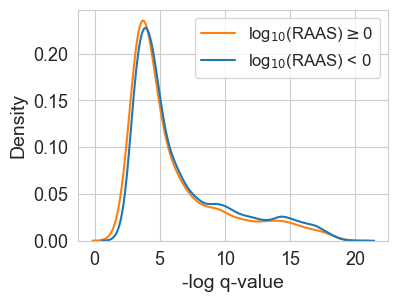

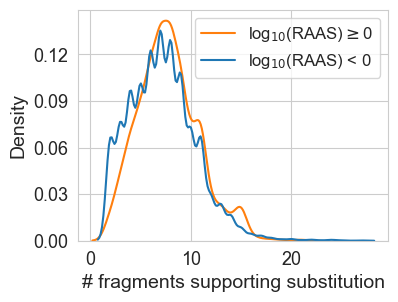

In [50]:
# Ext. Data Fig 2a,b
# generate a dictionary with PEP values and N fragments for all SAAP in all datasets 

paas_pep_dict = {}
for ds in datasets:
    print(ds)
    data_dir = data_dir_list[datasets.index(ds)]
    samples = samples_list[datasets.index(ds)]
    mtp_dict = pickle.load(open(data_dir + 'Ion_validated_MTP_dict.p', 'rb'))
    mtp_quant_dict = pickle.load(open(data_dir + 'MTP_quant_dict.p', 'rb'))

    plot_rows = []
    plot_cols = ['Dataset', 'Sample', 'PAAS', 'PAAS_val_idx', 'DP PEP', 'PAAS PEP', 'PAAS q', 'PAAS Precursor Intensity','BP Precursor Intensity', 'Precursor RAAS', 'N fragments']
    for s in samples:
        s_dict = mtp_dict[s]
        for k, paas in s_dict['mistranslated sequence'].items():
            paas_pep = s_dict['Posterior subs probability'][k]
            paas_q = s_dict['q-value'][k]
            dp_pep = s_dict['DP PEP'][k]
            n_frags = s_dict['fragment_evidence'][k]
            q_dict = [i for i,v in mtp_quant_dict.items() if v['MTP_seq']==paas]
            if len(q_dict)>0:
                q_dict = mtp_quant_dict[q_dict[0]]
                paas_prec = q_dict['MTP_PrecInt'][s]
                bp_prec = q_dict['BP_PrecInt'][s]
                raas = q_dict['Prec_ratio'][s]
                if (~np.isnan(raas)) and (~np.isinf(raas)):
                    plot_rows.append([ds, s, paas, k, dp_pep, paas_pep, paas_q, paas_prec, bp_prec, raas, n_frags])
    plot_df = pd.DataFrame(plot_rows, columns=plot_cols)   
    paas_pep_dict[ds] = plot_df

pickle.dump(paas_pep_dict, open(outdir+'SAAP_PEP_dfs.p', 'wb'))

# create data frame for plot 
all_ds_plot_df = pd.concat([v for k,v in paas_pep_dict.items()])
all_ds_plot_df['RAAS group'] = ['$\geq$0' if raas>=0 else '<0' for i,raas in list(enumerate(all_ds_plot_df['Precursor RAAS'].values))]
all_ds_plot_df = all_ds_plot_df.loc[all_ds_plot_df['PAAS q']<=0.01]

# plot histogram of confidence values stratified by RAAS (Ext. Data Fig. 2a)
fig,ax = plt.subplots(figsize=(4,3))
all_ds_plot_df['-log q'] = [-np.log10(x) for x in all_ds_plot_df['PAAS q']]
high_raas_df = all_ds_plot_df.loc[all_ds_plot_df['Precursor RAAS']>=0]
low_raas_df = all_ds_plot_df.loc[all_ds_plot_df['Precursor RAAS']<0]
sns.kdeplot(data = high_raas_df.loc[~np.isinf(high_raas_df['-log q'])], x='-log q', fill=False, color=colors[1], label='log$_{10}$(RAAS)$\geq$0')
sns.kdeplot(data = low_raas_df.loc[~np.isinf(low_raas_df['-log q'])], x='-log q', fill=False, label='log$_{10}$(RAAS) < 0')
ax.tick_params('both', labelsize=13)
plt.ylabel('Density', fontsize=14)
plt.xlabel('-log q-value', fontsize=14)
plt.legend(fontsize=12)
plt.savefig(outdir+'RAASgroup_logq_hist.pdf', bbox_inches='tight')

# plot histogram of N fragments on substitution site stratified by RAAS (Ext. Data Fig. 2b)
fig,ax = plt.subplots(figsize=(4,3))
sns.kdeplot(data = high_raas_df.loc[~np.isinf(high_raas_df['-log q'])], x='N fragments', fill=False, color=colors[1], label='log$_{10}$(RAAS)$\geq$0')
sns.kdeplot(data = low_raas_df.loc[~np.isinf(low_raas_df['-log q'])], x='N fragments', fill=False, label='log$_{10}$(RAAS) < 0')
ax.tick_params('both', labelsize=13)
plt.ylabel('Density', fontsize=14)
plt.xlabel('# fragments supporting substitution', fontsize=14)
plt.yticks([0,0.03,0.06,0.09,0.12])
plt.legend(fontsize=12)
plt.savefig(outdir+'RAASgroup_Nfrags_hist.pdf', bbox_inches='tight')

<>:35: SyntaxWarning: invalid escape sequence '\g'
<>:35: SyntaxWarning: invalid escape sequence '\g'
/var/folders/jh/xlgb4y497ms2xscmydjlsrb40000gp/T/ipykernel_56726/3005790180.py:35: SyntaxWarning: invalid escape sequence '\g'
  high_str_list = ['RAAS$\geq$0']*len(high_errs)


CCRCC
UCEC
BRCA
LUAD
PDAC
LSCC
Healthy


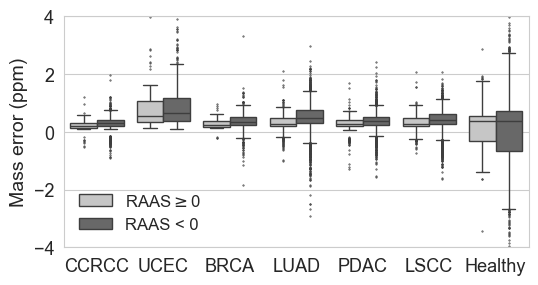

In [51]:
# Ext. Data Fig. 2c

def get_saap_mass_err(saap, s_saap_dict):
    saap_idx = [k for k,v in s_saap_dict['mistranslated sequence'].items() if v==saap]
    err = [s_saap_dict['Mass error (ppm)'][k] for k in saap_idx]
    return(np.median(err))

# create a dictionary with mass errors of SAAP with high and low RAAS
mass_err_dict = {ds:{'High RAAS mass error':[], 'Low RAAS mass error':[]} for ds in datasets}
for ds in datasets:
    data_dir = data_dir_list[datasets.index(ds)]
    ds_prec_df = filt_prec_quant_df.loc[filt_prec_quant_df['Dataset']==ds]   
    saap_dict = pickle.load(open(data_dir+'Ion_validated_MTP_dict.p','rb'))
    samples = samples_list[datasets.index(ds)]
    for s in samples:
        s_saap_dict = saap_dict[s]
        if 'Mass error (ppm)' in s_saap_dict.keys():
            s_prec_df = ds_prec_df.loc[ds_prec_df['TMT/Tissue']==s]
            high_saap = s_prec_df.loc[s_prec_df['RAAS']>=0, 'SAAP'].to_list()
            low_saap = s_prec_df.loc[s_prec_df['RAAS']<0, 'SAAP'].to_list()
            high_errs = [get_saap_mass_err(saap, s_saap_dict) for saap in high_saap]
            low_errs = [get_saap_mass_err(saap, s_saap_dict) for saap in low_saap]
            mass_err_dict[ds]['High RAAS mass error']  = mass_err_dict[ds]['High RAAS mass error'] + high_errs
            mass_err_dict[ds]['Low RAAS mass error']  = mass_err_dict[ds]['Low RAAS mass error'] + low_errs 
pickle.dump(mass_err_dict, open(outdir+'High_v_low_RAAS_mass_error_ppm.p','wb'))

# create dataframe for plot
plot_df_list = []
for ds in datasets:
    print(ds)
    ds_me_dict = mass_err_dict[ds]
    high_errs = ds_me_dict['High RAAS mass error']
    low_errs = ds_me_dict['Low RAAS mass error']
    ds_list = [ds]*len(high_errs+low_errs)
    high_str_list = ['RAAS$\geq$0']*len(high_errs)
    low_str_list = ['RAAS < 0']*len(low_errs)
    ds_plot_df = pd.DataFrame(zip(ds_list, high_errs+low_errs, high_str_list+low_str_list), columns=['Dataset', 'Mass error (ppm)', 'Peptide type'])
    plot_df_list.append(ds_plot_df)
plot_df = pd.concat(plot_df_list)

# plot distributions of mass errors for SAAP with high and low RAAS 
fig,ax = plt.subplots(figsize=(6,3))
sns.boxplot(data=plot_df, x='Dataset', hue='Peptide type', y='Mass error (ppm)', linewidth=1, fliersize=0.5, palette='Greys')
plt.ylabel('Mass error (ppm)', fontsize=14)
ax.tick_params('both', labelsize=13)
plt.xlabel('')
plt.ylim(-4,4)
plt.legend(loc='lower left', fontsize=12, frameon=False, ncol=1)
plt.savefig(outdir+'HighvLow_RAAS_Mass_error_boxplots.png', dpi=300, bbox_inches='tight')

### Extended data figure 2g,h,i: peptide detectability by DeepMSPeptide

In [52]:
# figures comparing peptide detectability between SAAP and BP 

# output from running DeepMSPeptide on SAAP and BP
detectability = pd.read_csv(dependencies_dir+'All_peptides_for_DeepMSPeptide_Predictions.txt', sep='\t')

def get_detectability(pep, detectability):
    detect_prob = detectability.loc[detectability['Peptide']==pep, 'Prob'].values[0]
    return(detect_prob)

filt_saap_df['SAAP_detect_prob'] = filt_saap_df.apply(lambda x: get_detectability(x['SAAP'], detectability), axis=1)
filt_saap_df['BP_detect_prob'] = filt_saap_df.apply(lambda x: get_detectability(x['BP'], detectability), axis=1)
filt_saap_df['detect_prob_diff'] = [filt_saap_df['BP_detect_prob'].to_list()[i] -  filt_saap_df['SAAP_detect_prob'].to_list()[i] for i in range(len(filt_saap_df))]


saap_detect_prob = filt_saap_df['SAAP_detect_prob'].to_list()
bp_detect_prob = filt_saap_df['BP_detect_prob'].to_list() 

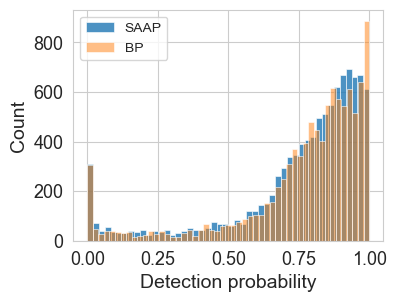

In [53]:
# plot histogram with SAAP and BP peptide detectability (Ext. Data Fig. 2g)
fig,ax = plt.subplots(figsize=(4,3))
sns.histplot(saap_detect_prob, alpha=0.8, label='SAAP')
sns.histplot(bp_detect_prob, alpha=0.5,color=colors[1], label='BP')
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles, labels=labels)
plt.xlabel('Detection probability', fontsize=14)
plt.ylabel('Count', fontsize=14)
ax.tick_params('both', labelsize=13)
plt.savefig(outdir+'All_peptide_detect_prob_hist.pdf', bbox_inches='tight')
#plt.close()


0.0


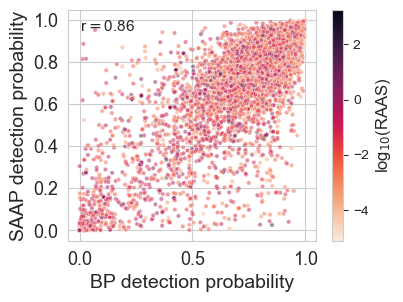

In [54]:

# plot a correlation plot of SAAP to BP peptide detectability (Ext. Data Fig. 2h)
fig,ax = plt.subplots(figsize=(4,3))
sns.scatterplot(data = filt_saap_df, y='SAAP_detect_prob', x='BP_detect_prob', hue='Mean precursor RAAS', alpha=0.5, s=10, linewidth=0.5, palette='rocket_r')
plt.xlabel('BP detection probability', fontsize=14)
plt.ylabel('SAAP detection probability', fontsize=14)
ax.tick_params('both', labelsize=13)
r,p = sp.stats.pearsonr(saap_detect_prob, bp_detect_prob)
print(p)
ax.annotate('r$=$'+str(np.round(r,2)), xy=(0,0.95), fontsize=11)

norm = plt.Normalize(filt_saap_df['Mean precursor RAAS'].min(), filt_saap_df['Mean precursor RAAS'].max())
sm = plt.cm.ScalarMappable(cmap="rocket_r", norm=norm)
sm.set_array([])

ax.get_legend().remove()
cb= ax.figure.colorbar(sm,ax=ax)
cb.set_label(label='log$_{10}$(RAAS)', size=12)
plt.savefig(outdir+'All_peptide_detect_prob_corr.png', dpi=300, bbox_inches='tight')
#plt.close()
plt.show()

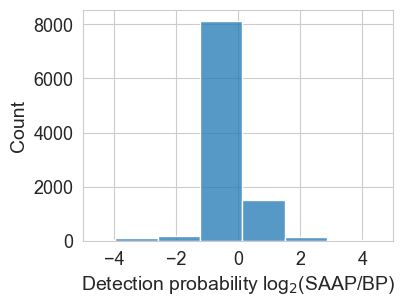

In [55]:
# plot a distribution of the fold changes between SAAP and BP peptide detectability (Ext. Data Fig. 2i)
ie_fc = [np.log2(saap_detect_prob[i]/bp_detect_prob[i]) for i in range(len(saap_detect_prob)) if saap_detect_prob[i]/bp_detect_prob [i]]# < 500]
fig,ax=plt.subplots(figsize=(4,3))
sns.histplot(ie_fc, bins=20)
plt.xlabel('Detection probability log$_2$(SAAP/BP)', fontsize=14)
plt.ylabel('Count', fontsize=14)
ax.tick_params('both', labelsize=13)
plt.xlim([-5,5])
#plt.yscale('log')
plt.savefig(outdir+'All_saap_bp_detect_prob_FC.pdf', bbox_inches='tight')
#plt.close()

### Figure 2c, Extended Data Figure 2j: Consistency of RAAS values for same substitution detected in different peptides/enzymatic digests


In [56]:
aa_subs_dir = wang_data_dir

tonsil_saap_dict= pickle.load(open(aa_subs_dir+'Tonsil_SAAP_dict.p','rb'))
tonsil_bp_dict= pickle.load(open(aa_subs_dir+'Tonsil_BP_dict.p','rb'))

In [57]:
other_enz_list = ['Chymotrypsin', 'LysC', 'ArgC', 'GluC']

# get list of SAAPs across digests with the same substitution (using the index in the protein sequence)
prot_aas_idx_pairs = {}
for s, sdict in tonsil_saap_dict.items():
    prot_aas_idx_pairs[s] = []
    pep_ids = sdict['Peptide IDs']
    for p,pid in pep_ids.items():
        prot_aas_idx_pairs[s].append([pid['saap_prot_fasta_idx'], pid['saap_prot_idx']])
set_prot_aas_idx_pairs = [x for y in list(prot_aas_idx_pairs.values()) for x in y if len(x)>0]
saaps_each_pair = {str(pair):[x for x,v in prot_aas_idx_pairs.items() if pair in v] for pair in set_prot_aas_idx_pairs}
saaps_each_pair = {k:v for k,v in saaps_each_pair.items() if len(v)>1}
saap_lists_w_same_aas = []
for k,v in saaps_each_pair.items():
    if v not in saap_lists_w_same_aas:
        saap_lists_w_same_aas.append(v)

# generate dataframe with RAAS values for substitutions found in multiple digests 
plot_rows = []
plot_cols = ['Trypsin RAAS', 'Other RAAS', 'Digest', 'Same sequence', 'SAAP abundance']
for s, sdict in tonsil_saap_dict.items():
    if 'Trypsin' in sdict['Digests']:
        raas_dict = sdict['RAAS']
        trypsin_raas = np.log10(2**raas_dict['Trypsin'])
        saap_abund = sdict['SAAP abundance']['Trypsin']
        # include abundance values to stratify plot by SAAP abundance 
        if saap_abund>=1e10:
            saap_abund=10
        elif saap_abund>=1e9:
            saap_abund=9
        elif saap_abund>=1e8:
            saap_abund=8
        else:
            saap_abund=7
        for enz in other_enz_list:
            if enz in sdict['Digests'] :
                same_seq = True
            if enz in raas_dict:
                raas = np.log10(2**raas_dict[enz])
                plot_rows.append([trypsin_raas, raas, enz, same_seq, saap_abund])

for saap_pair in saap_lists_w_same_aas:
    sdict1 = tonsil_saap_dict[saap_pair[0]]
    sdict2 = tonsil_saap_dict[saap_pair[1]]
    if 'Trypsin' in sdict1['Digests']:
        trypsin_raas = np.log10(2**sdict1['RAAS']['Trypsin'])
        saap_abund = sdict1['SAAP abundance']['Trypsin']
        if saap_abund>=1e10:
            saap_abund=10
        elif saap_abund>=1e9:
            saap_abund=9
        elif saap_abund>=1e8:
            saap_abund=8
        else:
            saap_abund=7
        other_dig = sdict2['Digests']
        for dig in other_dig:
            if dig!='Trypsin':
                other_raas = np.log10(2**sdict2['RAAS'][dig])
                plot_rows.append([trypsin_raas, other_raas, dig, False, saap_abund])
    elif 'Trypsin' in sdict2['Digests']:
        trypsin_raas = np.log10(2**sdict2['RAAS']['Trypsin'])        
        saap_abund = sdict2['SAAP abundance']['Trypsin']
        if saap_abund>=1e10:
            saap_abund=10
        elif saap_abund>=1e9:
            saap_abund=9
        elif saap_abund>=1e8:
            saap_abund=8
        else:
            saap_abund=7
        other_dig = sdict1['Digests']
        for dig in other_dig:
            if dig!='Trypsin':
                other_raas = np.log10(2**sdict1['RAAS'][dig])       
                plot_rows.append([trypsin_raas, other_raas, dig, False, saap_abund])

plot_df = pd.DataFrame(plot_rows, columns=plot_cols)
plot_df = plot_df.replace(np.inf, np.nan)
plot_df = plot_df.replace(-np.inf, np.nan)
plot_df = plot_df.dropna()
plot_df.to_excel(outdir+'Trypsin_vs_other_digest_plot_df.xlsx')

/var/folders/jh/xlgb4y497ms2xscmydjlsrb40000gp/T/ipykernel_56726/931645817.py:24: RuntimeWarning: divide by zero encountered in log10
  trypsin_raas = np.log10(2**raas_dict['Trypsin'])
/var/folders/jh/xlgb4y497ms2xscmydjlsrb40000gp/T/ipykernel_56726/931645817.py:46: RuntimeWarning: divide by zero encountered in log10
  trypsin_raas = np.log10(2**sdict1['RAAS']['Trypsin'])


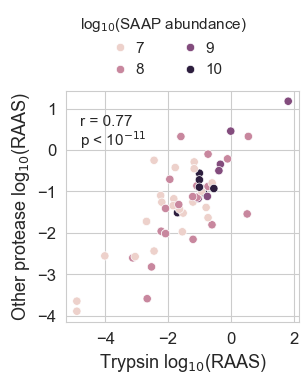

In [58]:
# plot RAAS of substitution in another digest vs RAAS of substitution in trypsin, colored by SAAP abundance
# Ext. Data Fig. 2g

sns.set_style('whitegrid')
fig,ax=plt.subplots(figsize=(3,3))
sns.scatterplot(data=plot_df, x='Trypsin RAAS', y='Other RAAS', hue='SAAP abundance')
plt.legend(loc='lower left', handletextpad=0, ncol=2, bbox_to_anchor=(0,1), frameon=False, fontsize=11, title='log$_{10}$(SAAP abundance)', title_fontsize=11)

r,p = sp.stats.pearsonr(plot_df['Trypsin RAAS'].to_list(), plot_df['Other RAAS'].to_list())
ax.text(-4.8,0.6, 'r = '+str(np.round(r, 2)), fontsize=11)
ax.text(-4.8,0.1, 'p < 10$^{-11}$', fontsize=11)

plt.ylabel('Other protease log$_{10}$(RAAS)', fontsize=13)
plt.xlabel('Trypsin log$_{10}$(RAAS)', fontsize=13)
ax.tick_params('both', labelsize=12)
plt.savefig(outdir+'tonsil_trypsinRAAS_vs_otherRAAS_scatter_saapabundcolor_newvalsearch.pdf', bbox_inches='tight')

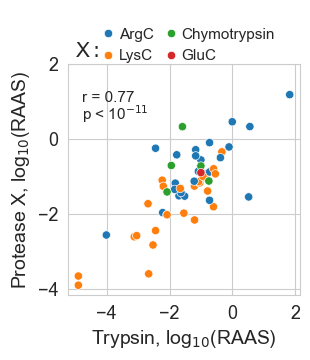

In [59]:
# plot RAAS of substitution in another digest vs RAAS of substitution in trypsin, colored by digest
# Fig. 2c

sns.set_style('whitegrid')
fig,ax=plt.subplots(figsize=(3,3))
sns.scatterplot(data=plot_df, x='Trypsin RAAS', y='Other RAAS', hue='Digest')
handles, labels = ax.get_legend_handles_labels()  
plt.legend(handles=handles, labels=labels, loc='center', bbox_to_anchor=(0.5,1.08),
           handletextpad=-0.3, ncol=2, frameon=False, fontsize=11, columnspacing=0.1)#, title='log$_{10}$(SAAP abundance)')
ax.annotate(r'X$:$', xy=(0.25,1.01), xycoords='figure fraction', fontsize=15)

r,p = sp.stats.pearsonr(plot_df['Trypsin RAAS'].to_list(), plot_df['Other RAAS'].to_list())
ax.text(-4.8,1, 'r = '+str(np.round(r, 2)), fontsize=11)
ax.text(-4.8,0.5, 'p < 10$^{-11}$', fontsize=11)
plt.yticks([-4,-2,0,2])

plt.ylabel('Protease X, log$_{10}$(RAAS)', fontsize=14)
plt.xlabel('Trypsin, log$_{10}$(RAAS)', fontsize=14)
ax.tick_params('both', labelsize=13)
plt.savefig(outdir+'tonsil_trypsinRAAS_vs_otherRAAS_scatter_digestseqcolor_newvalsearch.pdf', bbox_inches='tight')

### Extended Data FIgure 2k: Compare abundance of missed cleaved BPs to BPs without missed cleavages


In [60]:
# get data for plot from Supplemental_Data_2.SAAP_precursor_quant.xlsx

ds_bp_mc_dict = {ds:{} for ds in datasets}
for ds in datasets:
    ds_saap_df = filt_saap_df.loc[filt_saap_df['Dataset']==ds]
    bp_list_all = ds_saap_df['BP'].to_list()
    for i,row in ds_saap_df.iterrows():
        bp = row['BP']
        bp_list = [x for x in bp_list_all if x!=bp]
        mc = list(set([x for x in bp_list if bp in x]))
        if len(mc)>0:
            ds_bp_mc_dict[ds][bp] = mc
            
plot_rows = []
plot_cols = ['Dataset', 'BP', 'Missed cleavage BP', 'BP abundance', 'Missed cleavage BP abundance', 'AAS', 'AAS index', 'Color']
for ds in datasets:
    print(ds)
    ds_bp_mc = ds_bp_mc_dict[ds]
    ds_prec_df = filt_prec_quant_df.loc[filt_prec_quant_df['Dataset']==ds]
    samples = samples_list[datasets.index(ds)]
    for bp, mc_list in ds_bp_mc.items():
        for s in samples:
            s_df = ds_prec_df.loc[ds_prec_df['TMT/Tissue']==s]
            for mc in mc_list:
                if bp in s_df['BP'].to_list() and mc in s_df['BP'].to_list():
                    bp_df = s_df.loc[s_df['BP']==bp]
                    bp_abund = bp_df['BP abundance'].values[0]
                    aas = bp_df['AAS'].values[0]
                    saap = bp_df['SAAP'].values[0]
                    raas = bp_df['RAAS'].values[0]
                    aas_idx = [i for i,x in enumerate(saap) if bp[i]!=x][0]
                    mc_abund = s_df.loc[s_df['BP']==mc, 'BP abundance'].values[0]
                    if raas>0:
                        c = 'RAAS>0'
                    else:
                        c = 'RAAS<0'
                    plot_rows.append([ds, bp, mc, bp_abund, mc_abund, aas, aas_idx, c])
                    
plot_df = pd.DataFrame(plot_rows, columns=plot_cols)

CCRCC
UCEC
BRCA
LUAD
PDAC
LSCC
Healthy


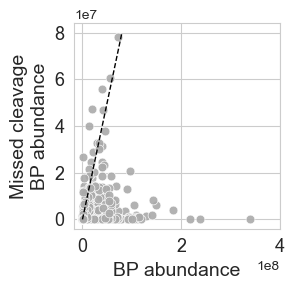

In [61]:
# plot scatterplot of abundance of BPs with missed cleavages to abundance of BPs

sns.set_style('whitegrid')
fig,ax = plt.subplots(figsize=(3,3))
sns.scatterplot(data=plot_df, x='BP abundance', y='Missed cleavage BP abundance', s=40, alpha=0.9, color='#AAAAAA')
ax.tick_params('both', labelsize=13)
plt.xlabel('BP abundance', fontsize=14)
plt.ylabel('Missed cleavage\nBP abundance', fontsize=14)
plt.plot((0,8e7), (0,8e7), '--k', linewidth=1)
plt.tight_layout()
plt.xticks([0,2e8,4e8])
plt.savefig(outdir+'All_missed_cleavage_BP_vs_BP_scatter.pdf')

### Extended Data Figure 3e: Upset plot of SAAP identified across datasets

Uses Supplemental_Data_2.SAAP_proteins.xlsx (filt_saap_df)

In [62]:
import upsetplot as up
import itertools

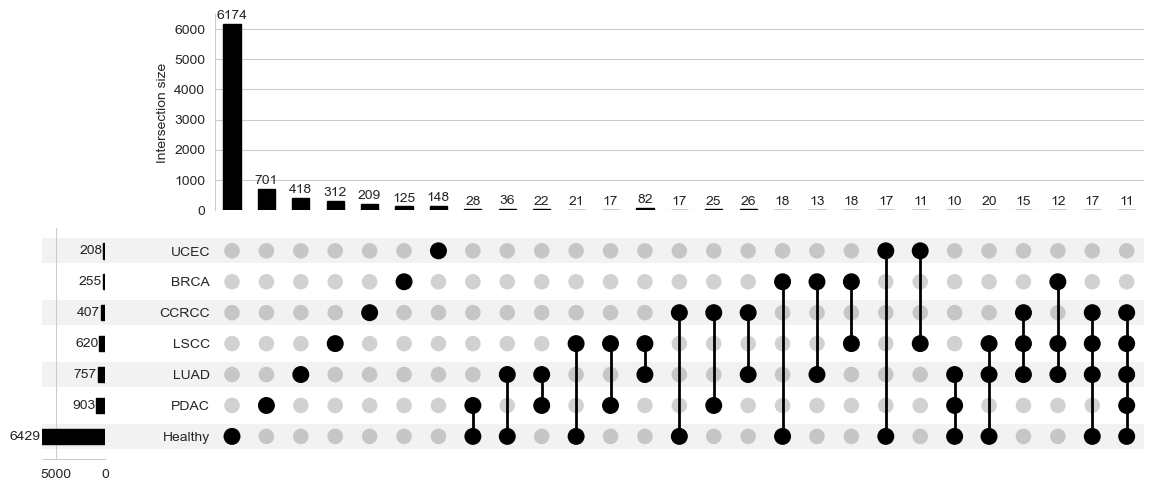

In [64]:
# get dataframe of the number of datasets each SAAP-BP pair is found in 
saap_bp = [row['SAAP']+':'+row['BP'] for i,row in filt_saap_df.iterrows()]
saap_bp_counter = Counter(saap_bp)
saap_bp_count_df = pd.DataFrame.from_dict(saap_bp_counter, columns=['N datasets'], orient='index')

def get_ds(saap, bp, filt_saap_df):
    """ function to get the list of datasets a given SAAP-BP pair is found in"""
    saap_bp_df = filt_saap_df.loc[(filt_saap_df['SAAP']==saap) & (filt_saap_df['BP']==bp)]
    ds_list = saap_bp_df['Dataset'].tolist()
    return(ds_list)

# addd column with the datasets each SAAP-BP pair is found in 
saap_bp_count_df['Datasets'] = ''
for i in saap_bp_count_df.index:
    saap = i.split(':')[0]
    bp = i.split(':')[1]
    ds_str = str(get_ds(saap, bp, filt_saap_df))
    saap_bp_count_df.loc[i,'Datasets'] = ds_str
    
# initiate index for upset plot dataframe 
l = [False, True]
arrays = [list(i) for i in itertools.product(l, repeat=7)]
arrays = np.transpose(arrays)
tuples = list(zip(*arrays))
multiindex = pd.MultiIndex.from_tuples(tuples, names=datasets)

# Create dataframe for upset plot 
saap_counts = []
idx = multiindex[1]
keepidx = []
for idx in multiindex:
    if True in idx:
        saap_ds = [datasets[i] for i,x in enumerate(idx) if x==True]
        n_saap_ds = len(saap_bp_count_df.loc[saap_bp_count_df['Datasets']==str(saap_ds)])
        if n_saap_ds>0:
            saap_counts.append(n_saap_ds)
            keepidx.append(idx)
keepidx = np.transpose(keepidx)
tuples = list(zip(*keepidx))
multiindex = pd.MultiIndex.from_tuples(tuples, names=datasets)
upset_plot_data = pd.Series(saap_counts, index=multiindex)

# plot upset plot
up.plot(upset_plot_data, show_counts=True, min_subset_size=10)
plt.savefig(outdir+'Upsetplot_n10_max_Healthy_updated.pdf', bbox_inches='tight')

### Extended Data Figure 3f: Percentage of samples of each dataset that SAAP identified in 6+ datasets ("shared SAAP") are found in

<>:47: SyntaxWarning: invalid escape sequence '\g'
<>:47: SyntaxWarning: invalid escape sequence '\g'
/var/folders/jh/xlgb4y497ms2xscmydjlsrb40000gp/T/ipykernel_56726/2399447866.py:47: SyntaxWarning: invalid escape sequence '\g'
  c.ax_heatmap.set_xlabel('SAAP in $\geq$6 datasets', fontsize=15)


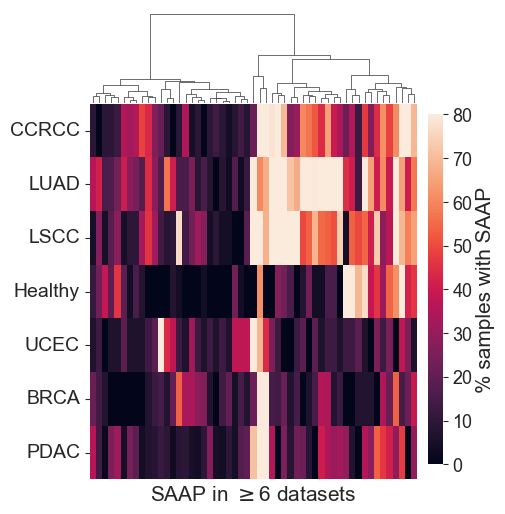

In [65]:
# add number of datasets each SAAP-BP pair is found in to data from supplemental_data_2,3,4

filt_saap_df['N datasets'] = filt_saap_df.apply(lambda x: len(get_ds(x['SAAP'], x['BP'], filt_saap_df)), axis=1)
filt_saap_df['Datasets'] = filt_saap_df.apply(lambda x: str(get_ds(x['SAAP'], x['BP'], filt_saap_df)), axis=1)
filt_reporter_quant_df['N datasets'] = filt_reporter_quant_df.apply(lambda x: len(get_ds(x['SAAP'], x['BP'], filt_saap_df)), axis=1)
filt_prec_quant_df['N datasets'] = filt_prec_quant_df.apply(lambda x: len(get_ds(x['SAAP'], x['BP'], filt_saap_df)), axis=1)

# get subsets of the dataframes for which the SAAP-BP pair is found in 6+ datasets
n6_saap_df = filt_saap_df.loc[filt_saap_df['N datasets']>=6]
n6_reporter_df = filt_reporter_quant_df.loc[filt_reporter_quant_df['N datasets']>=6]
n6_prec_df = filt_prec_quant_df.loc[filt_prec_quant_df['N datasets']>=6]

#  generate dataframe for heatmap showing in what percentage of samples does each shared saap come up in each dataset
shared_saap_bp_n6 = [i for i,row in saap_bp_count_df.iterrows() if row['N datasets']>=6]
n_samples_heatmap_df = pd.DataFrame(index=datasets, columns=shared_saap_bp_n6)
pcnt_samples_heatmap_df = pd.DataFrame(index=datasets, columns=shared_saap_bp_n6)

# dictionary with total number of samples in each dataset for computing percentages
n_total_samples_dict = {ds:0 for ds in datasets}
for ds in datasets:
    if ds != 'Healthy':
        sample_map = sample_map_list[datasets.index(ds)]
        n_total_samples = len(sample_map['sample_name'].values)
    else:
        n_total_samples = len(samples_list[datasets.index(ds)])
    n_total_samples_dict[ds] = n_total_samples
        
for saap_bp in shared_saap_bp_n6:
    saap = saap_bp.split(':')[0]
    bp = saap_bp.split(':')[1]
    for ds in datasets:
        if ds!='Healthy':
            ds_reporter_df = n6_reporter_df.loc[n6_reporter_df['Dataset']==ds]
            saap_bp_df = ds_reporter_df.loc[(ds_reporter_df['SAAP']==saap) & (ds_reporter_df['BP']==bp)]
        else:
            ds_prec_df = n6_prec_df.loc[n6_prec_df['Dataset']==ds]
            saap_bp_df = ds_prec_df.loc[(ds_prec_df['SAAP']==saap) & (ds_prec_df['BP']==bp)]
        n_samples = len(saap_bp_df)
        pcnt_samples = 100*n_samples/n_total_samples_dict[ds]
        n_samples_heatmap_df.loc[ds, saap_bp] = n_samples
        pcnt_samples_heatmap_df.loc[ds, saap_bp] = pcnt_samples
        
# plot as a heatmap
pcnt_samples_heatmap_df = pcnt_samples_heatmap_df.astype(float)
c = sns.clustermap(pcnt_samples_heatmap_df, figsize=(5,5), method='ward', xticklabels=False, vmin=0, vmax=80)
c.ax_row_dendrogram.set_visible(False)
c.ax_heatmap.set_xlabel('SAAP in $\geq$6 datasets', fontsize=15)
c.ax_heatmap.set_yticklabels(c.ax_heatmap.get_ymajorticklabels(), fontsize = 14)
c.ax_heatmap.set_facecolor('#F3F3F3')
c.ax_heatmap.yaxis.set_ticks_position('left')
c.ax_cbar.set_ylabel(r'% samples with SAAP', labelpad=3)
c.ax_cbar.set_position([0.87,0.06,0.03,0.7])
c.ax_cbar.yaxis.label.set_size(15)
c.ax_cbar.tick_params(labelsize=13)
c.savefig(outdir+'%_samples_all_ds_sharedSAAPn6_vmax80.pdf', bbox_inches='tight')

### Extended Data Figure 3g: RAAS distributions for shared SAAP (found in 6+ datasets)

Uses n6_saap_df, n6_reporter_df, n6_prec_df computed in above cell

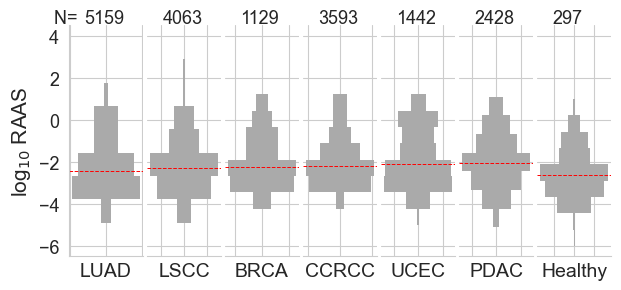

In [66]:
fig,axes = plt.subplots(1,len(datasets),figsize=(len(datasets),3), sharey=True)
plt.subplots_adjust(wspace=0.05)

sns.set_style('whitegrid')
for ax in axes:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params('x', bottom=False,labelbottom=False)
    if ax!=axes[0]:    

        ax.spines['left'].set_visible(False)
        ax.tick_params(left=False)
        
# compute medians to sort datasets by
medians = [np.nanmedian(n6_reporter_df.loc[n6_reporter_df['Dataset']==ds,'RAAS'].values) for ds in datasets[:-1]]
med_sort_idx = list(np.argsort(medians))
med_sort_idx.append(max(med_sort_idx)+1)

# plot violin plots
for i,ds in enumerate(datasets):
    ax_idx = med_sort_idx.index(i)
    axes[ax_idx].set_xlabel(ds, fontsize=14)
    if ds!='Healthy':
        ratio_data = [x for x in n6_reporter_df.loc[n6_reporter_df['Dataset']==ds,'RAAS'].values if ~np.isnan(x) and ~np.isinf(x)]
    else:
        ratio_data = [x for x in n6_prec_df.loc[n6_prec_df['Dataset']==ds,'RAAS'].values if ~np.isnan(x) and ~np.isinf(x)]
    bihist(ratio_data, ratio_data, nbins=10,h=axes[ax_idx])
    if ax_idx==0:
        axes[ax_idx].annotate('N= ', (-0.2,1.01), xycoords='axes fraction', fontsize=13)

    axes[ax_idx].annotate(str(len(ratio_data)), (0.21,1.01), xycoords='axes fraction', fontsize=13)
        
    axes[ax_idx].plot(axes[ax_idx].get_xlim(), (np.median(ratio_data), np.median(ratio_data)), '--r',linewidth=0.7)

axes[0].set_ylabel(r'log$_{10}$ RAAS', fontsize=15)
axes[0].tick_params('y',labelsize=13)
axes[0].set_yticks([-6,-4,-2,0,2,4]);
plt.savefig(outdir+'Sample_level_RAAS_allDS_SharedSAAPin6.pdf', bbox_inches='tight')

### Extended Data Figure 3h: Boxplots of mean RAAS relative to LUAD

CCRCC
UCEC
BRCA
LUAD
PDAC
LSCC
Healthy


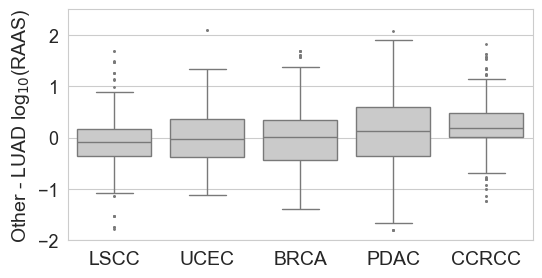

In [67]:
# initate dataframe for plot

plot_rows = []
plot_cols = ['LUAD RAAS', 'Other RAAS', 'SAAP','BP', 'LUAD-Other', 'Dataset']
for ds in datasets:
    print(ds)
    if ds != 'LUAD' and ds!='Healthy':
        luad_ds_rows = [i for i,row in filt_saap_df.iterrows() if 'LUAD' in row['Datasets'] and ds in row['Datasets']]
        luad_ds_df = filt_saap_df.loc[luad_ds_rows]
        saap_list = luad_ds_df['SAAP'].values
        bp_list = luad_ds_df['BP'].values
        
        saap_bp_list = [[saap_list[i], bp_list[i]] for i in range(len(saap_list))]
        for sb in saap_bp_list:
            saap = sb[0]
            bp = sb[1]
            sb_df = luad_ds_df.loc[(luad_ds_df['SAAP']==saap) & (luad_ds_df['BP']==bp)]
            ds_raas = sb_df.loc[sb_df['Dataset']==ds, 'Mean reporter RAAS'].values[0]
            luad_raas = sb_df.loc[sb_df['Dataset']=='LUAD', 'Mean reporter RAAS'].values[0]
            ds_luad_raas = ds_raas - luad_raas 
            plot_rows.append([luad_raas, ds_raas, saap, bp, ds_luad_raas, ds])
plot_df = pd.DataFrame(plot_rows, columns=plot_cols)

# plot data 
fig,ax = plt.subplots(figsize=(6,3))
sns.boxplot(data=plot_df, x='Dataset', y='LUAD-Other', color='#CACACA', order=['LSCC','UCEC','BRCA','PDAC','CCRCC'], fliersize=0.8)
plt.tick_params('y', labelsize=13)
plt.tick_params('x', labelsize=14)
plt.xlabel('')
plt.ylabel('Other - LUAD log$_{10}$(RAAS)', fontsize=14)
plt.ylim([-2,2.5])
plt.savefig(outdir+'Shared_SAAP_Rel2LUAD_boxplots.pdf', bbox_inches='tight')

### Figure 2f: Relative RAAS computed for shared SAAP between 2 patient samples
Analysis limited to CPTAC datasets

In [87]:
# Create a matrix with median  of relative RAAS computed for shared peptides between each pair of patients. Or read in below

all_ds_matrices = {}
ds_report_df = filt_reporter_quant_df.loc[filt_reporter_quant_df['Sample type']=='Tumor']
ds_report_df.sort_values('RAAS', inplace=True)
set_samples = list(set(ds_report_df['Sample name'].values))
ds_matrix_rowcol = pd.DataFrame(index=set_samples, columns=set_samples)

for sample1 in set_samples:
    sample1_df = ds_report_df.loc[ds_report_df['Sample name']==sample1]
    sample1_saap_bp = [sample1_df['SAAP'].to_list()[i]+':'+sample1_df['BP'].to_list()[i] for i in range(len(sample1_df))]

    other_samples = set_samples[set_samples.index(sample1):]
    for sample2 in other_samples:
        sample2_df = ds_report_df.loc[ds_report_df['Sample name']==sample2]
        sample2_saap_bp = [sample2_df['SAAP'].to_list()[i]+':'+sample2_df['BP'].to_list()[i] for i in range(len(sample2_df))]
        shared_saap_bp = [x for x in sample1_saap_bp if x in sample2_saap_bp]
        row_shared_raas_ratios = []
        col_shared_raas_ratios = []
        
        # for each SAAP shared between 2 patients, compute relative RAAS on log2 scale
        for sb, saap_bp in enumerate(shared_saap_bp):
            saap = saap_bp.split(':')[0]
            bp = saap_bp.split(':')[1]
            raas1 = sample1_df.loc[(sample1_df['SAAP']==saap) & (sample1_df['BP']==bp), 'RAAS'].values[0]
            raas2 = sample2_df.loc[(sample2_df['SAAP']==saap) & (sample2_df['BP']==bp), 'RAAS'].values[0]
            if ~np.isnan(raas1) and ~np.isnan(raas2) and ~np.isinf(raas1) and ~np.isinf(raas2):
                raas_ratio = raas1 - raas2
                raas_ratio = np.log2(10**raas_ratio)
                col_raas_ratio = raas2 - raas1
                col_raas_ratio = np.log2(10**col_raas_ratio)
                row_shared_raas_ratios.append(raas_ratio)
                col_shared_raas_ratios.append(col_raas_ratio)
        ds_matrix_rowcol.loc[sample1, sample2] = np.nanmedian(row_shared_raas_ratios)
        ds_matrix_rowcol.loc[sample2, sample1] = np.nanmedian(col_shared_raas_ratios)

all_ds_matrices['All_data'] = {'Row_col':ds_matrix_rowcol}

# Add N SAAP per comparison to all_data matrix
ds_report_df = filt_reporter_quant_df.loc[filt_reporter_quant_df['Sample type']=='Tumor']
ds_report_df.sort_values('RAAS', inplace=True)
set_samples = list(set(ds_report_df['Sample name'].values))

ds_matrix_rowcol = pd.DataFrame(index=set_samples, columns=set_samples)
for i,sample1 in enumerate(set_samples):
    if i%100==0:
        print(i)
    sample1_df = ds_report_df.loc[ds_report_df['Sample name']==sample1]
    sample1_saap_bp = [sample1_df['SAAP'].to_list()[i]+':'+sample1_df['BP'].to_list()[i] for i in range(len(sample1_df))]
    other_samples = set_samples[set_samples.index(sample1):]
    for sample2 in other_samples:
        sample2_df = ds_report_df.loc[ds_report_df['Sample name']==sample2]
        sample2_saap_bp = [sample2_df['SAAP'].to_list()[i]+':'+sample2_df['BP'].to_list()[i] for i in range(len(sample2_df))]
        shared_saap_bp = [x for x in sample1_saap_bp if x in sample2_saap_bp]
        ds_matrix_rowcol.loc[sample1, sample2] = len(shared_saap_bp)
        ds_matrix_rowcol.loc[sample2, sample1] = len(shared_saap_bp)

all_ds_matrices['All_data']['N_shared_saap'] = ds_matrix_rowcol

pickle.dump(all_ds_matrices, open(outdir+'All_pairwise_sample_RAAS_ratio_matrices_log2.p', 'wb'))

/var/folders/jh/xlgb4y497ms2xscmydjlsrb40000gp/T/ipykernel_56726/830114152.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_report_df.sort_values('RAAS', inplace=True)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/var/folders/jh/xlgb4y497ms2xscmydjlsrb40000gp/T/ipykernel_56726/830114152.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_report_df.sort_values('RAAS', inplace=True)


0
100
200
300
400
500
600


/var/folders/jh/xlgb4y497ms2xscmydjlsrb40000gp/T/ipykernel_56726/2484102101.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_df, x='Median log$_{10}$(RAAS) ratio', y='Index', palette='RdBu_r', saturation=1,linewidth=0)


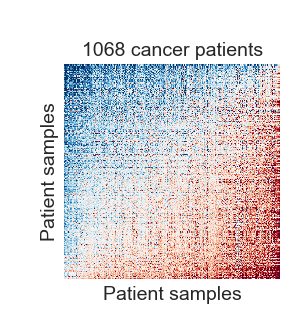

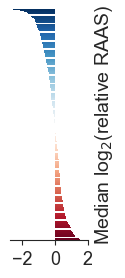

In [88]:
# plot heatmnap sorted by row/col median 
ds = 'All_data'

ds_matrix = all_ds_matrices[ds]['Row_col'].astype(float)
medians = [np.median([x for x in row.values if ~np.isnan(x)]) for i,row in ds_matrix.iterrows()]
srt_idx = np.argsort(medians)
col_medians = [np.median([x for x in ds_matrix[col].to_list() if ~np.isnan(x)]) for col in ds_matrix.columns]
col_srt_idx = np.argsort(col_medians)
plot_matrix = ds_matrix.iloc[srt_idx, col_srt_idx]


c = sns.clustermap(plot_matrix, row_cluster=False, col_cluster=False, cmap='RdBu_r', center=0, robust=True, 
                   yticklabels=False, xticklabels=False, figsize=(3,3))#, cbar_kws={'ticklocation':'left'})
c.ax_cbar.set_visible(False)
c.ax_heatmap.set_xlabel('Patient samples', fontsize=14)
c.ax_heatmap.set_ylabel('Patient samples', fontsize=14)
c.ax_heatmap.yaxis.set_label_position('left')
c.ax_heatmap.set_title('1068 cancer patients', fontsize=14)

c.savefig(outdir+ds+'_Paired_RAAS_ratios_btwn_samples_median_sorted_rowcol_log2_nocbar.pdf', bbox_inches='tight')
c.savefig(outdir+ds+'_Paired_RAAS_ratios_btwn_samples_median_sorted_rowcol_log2_nocbar.png', dpi=300, bbox_inches='tight')

medians = [np.median([x for x in row.values if ~np.isnan(x)]) for i,row in plot_matrix.iterrows()]

# barplot of patient medians
srt_medians = [medians[i] for i in srt_idx]
str_srt_idx = [str(x) for x in srt_idx]
plot_df = pd.DataFrame(zip(str_srt_idx, srt_medians), columns=['Index','Median log$_{10}$(RAAS) ratio'])
plot_df.sort_values('Median log$_{10}$(RAAS) ratio', inplace=True)

sns.set_style('ticks')
fig,ax = plt.subplots(figsize=(1,3))
sns.barplot(data=plot_df, x='Median log$_{10}$(RAAS) ratio', y='Index', palette='RdBu_r', saturation=1,linewidth=0)
ax.set_ylabel(None)
ax.set_yticks([]);
ax.tick_params('x', labelsize=13)
plt.ylabel('Median log$_{2}$(relative RAAS)', fontsize=14)
plt.xlabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticks([-2,0,2]);
ax.yaxis.set_label_position('right')
plt.savefig(outdir+ds+'_Paired_RAAS_ratios_btwn_samples_median_barplot_log2.pdf', bbox_inches='tight')

### Figure 2g: weighted means of relative RAAS for each patient in each dataset


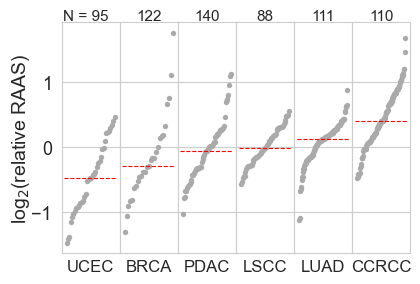

In [90]:
# plot weighted mean 

def weighted_mean(vals, ns):
    """ function to get mean weighted by the number of shared SAAP """
    wmean = np.sum([vals[i]*ns[i] for i in range(len(vals))])/np.sum(ns)
    return(wmean)

all_ds_matrices = pickle.load(open(outdir+'All_pairwise_sample_RAAS_ratio_matrices_log2.p', 'rb'))
all_ds_matrix = all_ds_matrices['All_data']['Row_col'].astype(float)
all_ds_n_matrix = all_ds_matrices['All_data']['N_shared_saap'].astype(float)

sns.set_style('whitegrid')
fig,axes = plt.subplots(1, 6, figsize=(4.5,3), sharey=True)
plt.subplots_adjust(wspace=0)

# get medians for sorting datasets in plot
medians = []
for i,ds in enumerate(datasets[:-1]):
    ds_sample_map = sample_map_list[datasets.index(ds)]
    ds_samples = list(set(ds_sample_map['sample_name'].to_list()))
    ds_matrix = all_ds_matrix.loc[[r for r,row in all_ds_matrix.iterrows() if r in ds_samples]]#, [c for c in all_ds_matrix.columns if c in ds_samples]]
    n_matrix = all_ds_n_matrix.loc[[r for r,row in all_ds_n_matrix.iterrows() if r in ds_samples]]
    weighted_means = [weighted_mean(ds_matrix.loc[r], row) for r,row in n_matrix.iterrows()]
    vals = [x for x in weighted_means  if ~np.isnan(x)]
    medians.append(np.median(vals))
srt_idx = np.argsort(medians)
ds_sorted = [datasets[:-1][i] for i in srt_idx]

# plot weighted means 
for i,ds in enumerate(ds_sorted):
    ax = axes[i]
    ds_sample_map = sample_map_list[datasets.index(ds)]
    ds_samples = list(set(ds_sample_map['sample_name'].to_list()))
    ds_matrix = all_ds_matrix.loc[[r for r,row in all_ds_matrix.iterrows() if r in ds_samples]]#, [c for c in all_ds_matrix.columns if c in ds_samples]]
    n_matrix = all_ds_n_matrix.loc[[r for r,row in all_ds_n_matrix.iterrows() if r in ds_samples]]
    
    weighted_means = [weighted_mean(ds_matrix.loc[r], row) for r,row in n_matrix.iterrows()]
    vals = weighted_means
    srt_idx = np.argsort(vals)
    srt_vals = [vals[s] for s in srt_idx]
    plot_df = pd.DataFrame(zip(list(range(len(vals))), srt_vals), columns=['Rank', 'RAAS ratio'])

    sns.scatterplot(data=plot_df, y='RAAS ratio', x='Rank', ax=ax, linewidth=0, s=15, color='#AAAAAA')
    ax.set_xlabel(ds, fontsize=12)
    ax.set_xticks([])
    n = len(srt_vals)
    if i == 0:
        ax.annotate('N = '+str(int(np.round(n, 0))), xy=(0.8,1.01), xycoords='axes fraction', ha='right', fontsize=11)
    else:
        ax.annotate(str(int(np.round(n, 0))), xy=(0.5,1.01), xycoords='axes fraction', ha='center', fontsize=11)
    median = np.median([x for x in vals if ~np.isnan(x)])
    ax.plot(ax.get_xlim(), (median,median), '--r', linewidth=0.8)
    
axes[0].set_yticks([-1, 0, 1])
axes[0].tick_params('y', labelsize=13)
axes[0].set_ylabel('log$_{2}$(relative RAAS)', fontsize=14, labelpad=-0.5)

plt.savefig(outdir+'All_Paired_RAAS_ratios_btwn_samples_ranksort_allVals_log2_ds_numerator_allotherds_denom_weighted_mean.pdf', bbox_inches='tight')

### Figure 2i. SAAP  copy number estimates 

In [ ]:
# compute the abundance of core histone proteins using precursor ion intensity summed over isoforms mapping to each core histone

histone_prot_abund_dict = {}
for ds in datasets:
    print(ds)
    data_dir = data_dir_list[datasets.index(ds)]
    
    # prot_dict and blast_map are computed as downstream part of decode pipeline. Provided in Google Drive. 
    prot_dict = pickle.load(open(data_dir+'Allprot_normalized_abundance_dict.p', 'rb'))
    blast_map = pd.read_excel(data_dir+'blast_map_w_gene.xlsx', index_col=0)
    samples = samples_list[datasets.index(ds)]

    histone1_protein_rows = [i for i,row in blast_map.iterrows() if re.search('histone H1', row['Blast protein'])]
    histone1_proteins = blast_map.loc[histone1_protein_rows, 'Protein name'].to_list()
    histone2_protein_rows = [i for i,row in blast_map.iterrows() if re.search('histone H2', row['Blast protein'])]
    histone2_proteins = blast_map.loc[histone2_protein_rows, 'Protein name'].to_list()
    histone3_protein_rows = [i for i,row in blast_map.iterrows() if re.search('histone H3', row['Blast protein'])]
    histone3_proteins = blast_map.loc[histone3_protein_rows, 'Protein name'].to_list()
    histone4_protein_rows = [i for i,row in blast_map.iterrows() if re.search('histone H4', row['Blast protein'])]
    histone4_proteins = blast_map.loc[histone4_protein_rows, 'Protein name'].to_list()

    # dict of total histone protein abundance in each patient sample
    histone_prot_abund_dict[ds] = {}
    for s in samples:
        prot_df = prot_dict[s]
        histone1_prots = prot_df.loc[[x for x in histone1_proteins if x in prot_df.index], 'Precursor intensity'].sum()
        histone2_prots = prot_df.loc[[x for x in histone2_proteins if x in prot_df.index], 'Precursor intensity'].sum()
        histone3_prots = prot_df.loc[[x for x in histone3_proteins if x in prot_df.index], 'Precursor intensity'].sum()
        histone4_prots = prot_df.loc[[x for x in histone4_proteins if x in prot_df.index], 'Precursor intensity'].sum()
        histone_prot_abund_dict[ds][s] = np.median([histone1_prots, histone2_prots, histone3_prots, histone4_prots])

pickle.dump(histone_prot_abund_dict, open(outdir+'Histone_prot_median_precursor_abundance_dict_sumsubtypes.p','wb'))

CCRCC
UCEC
BRCA
LUAD
PDAC
LSCC
Healthy


In [84]:
histone_prot_abund_dict = pickle.load(open(dependencies_dir+'Histone_prot_median_precursor_abundance_dict_sumsubtypes.p','rb'))

In [85]:
# compute copy number estimates for SAAP based on their protein abundances and histone abundances
# uses "histone ruler" method assuming 30e6 copy number for histone proteins

plot_rows = []
plot_cols = ['Dataset', 'SAAP', 'Sample name', 'SAAP abundance', 'Histone abundance', 'SAAP/Histone']
for ds in datasets:
    print(ds)
    ds_quant_df = filt_prec_quant_df.loc[filt_prec_quant_df['Dataset']==ds]
    saaps = list(set(ds_quant_df['SAAP'].values))
    samples = list(set(ds_quant_df['TMT/Tissue'].values))
    samples = [x for x in samples if x!='tonsil']

    for sample in samples:
        histone_abund = histone_prot_abund_dict[ds][sample]
        for saap in saaps:
            saap_abund = ds_quant_df.loc[(ds_quant_df['SAAP']==saap) & (ds_quant_df['TMT/Tissue']==sample), 'SAAP abundance'].values
            if len(saap_abund)>0: # not all SAAP in every sample
                saap_abund = saap_abund[0]
                saap_histone = saap_abund/histone_abund
                plot_rows.append([ds, saap, sample, saap_abund, histone_abund, saap_histone])

plot_df = pd.DataFrame(plot_rows, columns=plot_cols)
plot_df['SAAP copies'] = plot_df.apply(lambda x: np.round(30e6*x['SAAP/Histone']), axis=1)
plot_df.to_excel(outdir+'SAAP_copy_estimate_by_median_histone_sumsubtypes_precursors.xlsx')

CCRCC
UCEC
BRCA
LUAD
PDAC
LSCC
Healthy


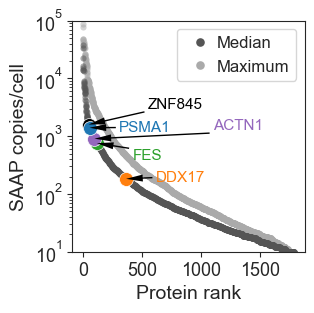

In [86]:
# plot median and max SAAP copy numbers in rank sorted order, highlighting substituted proteins of interest
prec_saap_copy_number_df = plot_df
genes = []
pfam = []
refprot = []

for i,row in prec_saap_copy_number_df.iterrows():
    ds = row['Dataset']
    saap = row['SAAP']
    prot_row = filt_saap_df.loc[(filt_saap_df['Dataset']==ds) & (filt_saap_df['SAAP']==saap)]
    if len(prot_row)>0:
        genes.append(prot_row['Genes'].values[0])
        pfam.append(prot_row['Pfam domains'].values[0])
        refprot.append(prot_row['Reference protein (blast)'].values[0])
    else:
        genes.append('')
        pfam.append('')
        refprot.append('')

prec_saap_copy_number_df['Genes'] = genes
prec_saap_copy_number_df['Pfam'] = pfam
prec_saap_copy_number_df['RefProt'] = refprot

# combine peptides across all datasets with median and max
rows = []
cols = ['SAAP', 'Median SAAP copies', 'Genes','Pfam', 'RefProt', 'Max SAAP copies']
ds_df = prec_saap_copy_number_df.loc[prec_saap_copy_number_df['Dataset']!='Healthy']
ds_saap = list(set(ds_df['SAAP'].to_list()))
for saap in ds_saap:
    saap_df = ds_df.loc[ds_df['SAAP']==saap]
    median_copies = saap_df['SAAP copies'].median()
    max_copies = saap_df['SAAP copies'].max()
    genes = saap_df['Genes'].to_list()[0]
    pfam = saap_df['Pfam'].to_list()[0]
    refprot = saap_df['RefProt'].to_list()[0]
    rows.append([saap, median_copies, genes, pfam, refprot, max_copies]) 
median_prec_saap_copy_number_df = pd.DataFrame(rows, columns=cols)

# generate plot 
rank_df = median_prec_saap_copy_number_df.loc[median_prec_saap_copy_number_df['Median SAAP copies']>=10, ['SAAP','Median SAAP copies', 'Max SAAP copies']]

sns.set_style('ticks')
fig,ax = plt.subplots(figsize=(3,3))
rank_df.sort_values('Max SAAP copies', ascending=False, inplace=True)
rank_df.reset_index(inplace=True, drop=True)
rank_df['Rank'] = rank_df.index
sns.scatterplot(data=rank_df, x='Rank', y='Max SAAP copies', color='#AAAAAA', linewidth=0, s=80, marker='.', alpha=0.5)

rank_df.sort_values('Median SAAP copies', ascending=False, inplace=True)
rank_df.reset_index(inplace=True, drop=True)
rank_df['Rank'] = rank_df.index

sns.scatterplot(data=rank_df, x='Rank', y='Median SAAP copies', color='#555555', linewidth=0, s=80, marker='.', alpha=0.5)
sns.scatterplot(data=rank_df.loc[rank_df['SAAP']=='ADNTLVAYK'], x='Rank', y='Median SAAP copies', color=colors[2], linewidth=0.5, s=100)#, label='FES')
sns.scatterplot(data=rank_df.loc[rank_df['SAAP']=='LIDLLESGK'], x='Rank', y='Median SAAP copies', color=colors[1], linewidth=0.5, s=100)#, label='DDX17')
sns.scatterplot(data=rank_df.loc[rank_df['SAAP']=='VLAVNQEHEQLMEDYEK'], x='Rank', y='Median SAAP copies', color=colors[4], linewidth=0.5, s=100)#, label='DDX17')
sns.scatterplot(data=rank_df.loc[rank_df['SAAP']=='IIHLGGK'], x='Rank', y='Median SAAP copies', color='k', linewidth=0.5, s=100)#, label='DDX17')
sns.scatterplot(data=rank_df.loc[rank_df['SAAP']=='AGSELAAHQK'], x='Rank', y='Median SAAP copies', color=colors[0], linewidth=0.5, s=100)#, label='PSMA1')

saap2plot = ['ADNTLVAYK', 'LIDLLESGK', 'VLAVNQEHEQLMEDYEK', 'IIHLGGK', 'AGSELAAHQK']
ranks2plot = [rank_df.loc[rank_df['SAAP']==saap, 'Rank'].values[0] for saap in saap2plot]
texts2plot = ['FES','DDX17', 'ACTN1', 'ZNF845', 'PSMA1']
colors2plot = [colors[2], colors[1], colors[4], 'black', colors[0]]
for i,rank in enumerate(ranks2plot):
    txt = texts2plot[i]
    y = rank_df.loc[rank_df['Rank']==rank,'Median SAAP copies']
    if txt=='DDX17' or txt=='PSMA1':
        ax.annotate(txt, xy=(rank,y), xytext=(rank+250,y+10), xycoords='data', textcoords='data', va='center',
                arrowprops=dict(facecolor='k', headwidth=5,width=1, linewidth=0), color=colors2plot[i], fontsize=11)
    elif txt=='ZNF845':
        ax.annotate(txt, xy=(rank,y), xytext=(rank+500,y+2000), xycoords='data', textcoords='data', va='center',
            arrowprops=dict(facecolor='k', headwidth=5,width=1, linewidth=0), color=colors2plot[i], fontsize=11)
    elif txt=='ACTN1':
        ax.annotate(txt, xy=(rank,y), xytext=(rank+1000,y+600), xycoords='data', textcoords='data', va='center',
                arrowprops=dict(facecolor='k', headwidth=5,width=1, linewidth=0), color=colors2plot[i], fontsize=11)
    elif txt=='FES':
        ax.annotate(txt, xy=(rank,y), xytext=(rank+300,y-300), xycoords='data', textcoords='data', va='center',
                arrowprops=dict(facecolor='k', headwidth=5,width=1, linewidth=0), color=colors2plot[i], fontsize=11)
        
plt.ylim([10,1e5])
plt.yscale('log')
ax.tick_params('both', labelsize=13)
plt.ylabel('SAAP copies/cell', fontsize=14)
plt.xlabel('Protein rank', fontsize=14)
handles = [Line2D([0],[0], marker='o', color='w', label='Median', markerfacecolor='#555555'),
          Line2D([0],[0], marker='o', color='w', label='Maximum', markerfacecolor='#AAAAAA')]
plt.legend(handles=handles, fontsize=12, handletextpad=0, markerscale=1.2, frameon=True)
plt.savefig(outdir+'SAAP_copies_median_histone_sumsubtypes_rankplot_ticks_gr10copies_noHealthy_PSMA1_w_max.pdf', bbox_inches='tight')